## Current status
- The current goal is to make standard QAOA work with adiabatic-like trajectories.
- L-BFGS-B optimizer (bounded) needs a lot of layers to find the factorization solution. From $p \sim 40$ layers, the
angle trajectories stops being quasi-adiabatic: some oscillations and sudden drops appear for $\gamma$.
- BFGS (unbounded) finds the solution with fidelity $1$ using only $p \sim 30$ layers. For L-BFGS-B, we need more than
$100$ layers to achieve comparable results. BFGS doesn't reflect any similarity to adiabaticity.

### Things I've tried
- Multiple definitions for max_gamma ($\gamma \in [0, \text{max\_gamma}]$): using maximum E, norm of E, two or three times the original definition, etc.
- Multiple allowed intervals for $\beta$: $[0, \pi],~[0, 2\pi],~[0, \pi/2],~[-\pi/4, \pi/4],~\dots$
- Multiple optimizers: BFGS, L-BFGS-B, COBYLA, Nelder-Mead
- Multiple optimizer options: tolerances, maximum iterations, etc.
- Rescaling Hamiltonians: max_E $\rightarrow$ 1

### Things I've checked
- Cost Hamiltonians are defined correctly, encoding the solution in the ground state.
- For $p=1$ layer, multiple initializations converge to the same optimal point. The cost function only has one minimum
in the main branch for $\gamma$ and $\beta$.
- Gradients are computed correctly, double checked against the energy profile.
- Interpolation is computed correctly.

### Doubts
- I understand that it's been observed that optimal QAOA trajectories tend to mimic adiabatic passages for MaxCut and
QUBO problems. Is our problem really a QUBO problem?
- Should the trajectories be perfectly adiabatic or some oscillations are accepted?
- With current results (BFGS), can we draw any conclusions concerning adiabatic factorization?

### Next steps
- Explore adiabaticity in our method. Linear hamiltonian. N=39
- Try boundary approach with our method. N=39
- Explore N=51 or N=77.
- Prepare presentation with results: boundary vs best for standard, bounded (start with +-+-+) vs unbounded for linear (¿adiabatic?)

https://arxiv.org/pdf/2309.15162

## Preprocessing

In [14]:
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
from IPython.display import display, Markdown, Latex

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        result['filepath'] = result_file
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]

In [16]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['energy_max'] = experiment_results['Ec'].apply(lambda E: np.max(E))
experiment_results['energy_norm'] = experiment_results['Ec'].apply(lambda E: np.linalg.norm(E))
experiment_results['energy_avg'] = experiment_results['Ec'].apply(lambda E: np.average(E))

max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['cost'].max().reset_index()
max_costs = max_costs.rename(columns={'cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['cost_rescaled'] = experiment_results['cost'] / experiment_results['max_cost']

In [17]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
]

## Comparison between optimizers (N = 15)

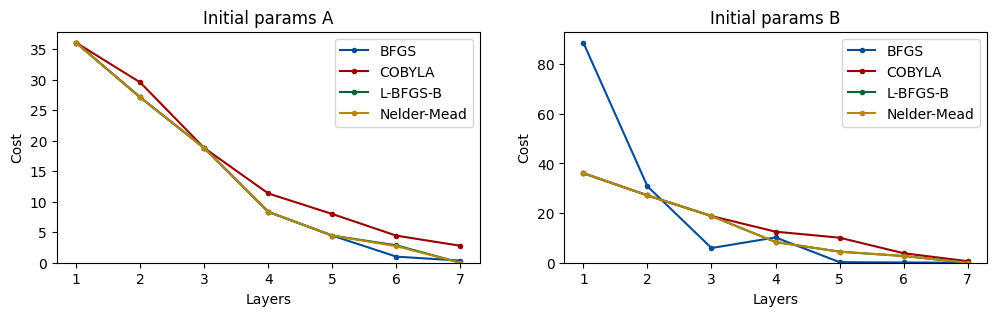

In [5]:
df = experiment_results[(experiment_results['N']==15) & (experiment_results['setup']=='standard')]
df = df.rename(columns={'optimizer_success': 'opt_succ'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

for j, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_opt = df[(df.optimizer == optimizer)]

    df_a = df_opt[df_opt['gamma_0'].round(5)==0.00557]
    axs[0].set_title('Initial params A')
    axs[0].plot('layers', 'cost', data=df_a, marker='.', color=plot_colors[j+1][0], label=optimizer)

    df_b = df_opt[df_opt['gamma_0'].round(5)==0.00058]
    axs[1].set_title('Initial params B')
    axs[1].plot('layers', 'cost', data=df_b, marker='.', color=plot_colors[j+1][0], label=optimizer)

for ax in axs:
    ax.set_ylabel('Cost')
    ax.set_xlabel('Layers')
    ax.set_ylim(0)
    ax.legend(loc='best')

* L-BFGS-B is the best overall optimizer among the tested methods.
* Nelder-Mead's performance is similar to L-BFGS-B, but it is in the limit of scalability.
* COBYLA has a good performance as long as a huge amount of steps are allowed, making it the
slowest of the tested methods. Even with that, the optimizer finds difficulties to succeed in
multiple occasions. It doesn't seem very appropriate for our problem.
* Since BFGS is unbounded, it is the least predictable method due to the QAOA periodic nature: $\exp (i \gamma H)$.
Interestingly, BFGS found better solutions than L-BFGS-B for some layers and converged to the problem's solution. It is sensitive to initial conditions.

## Preliminar analysis

### One Layer

0.033780566167632184


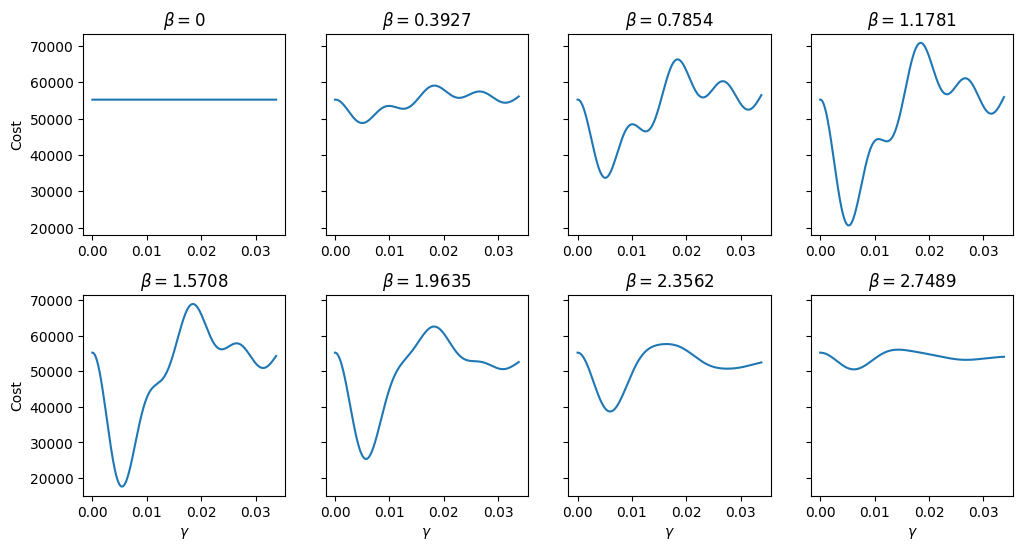

In [6]:
solver = QAOASolver(187, problem_hamiltonian='linear_H', cost_hamiltonian='quadratic_H')

# Max angle
max_gamma = 2*np.pi/max(solver.Ep)
print(max_gamma)

gammas = np.linspace(0, max_gamma, 10000)
betas = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8]

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey='row', sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost([gamma, beta])
        cost.append(res)

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})

    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

### Two Layers

0.0014424208694168012


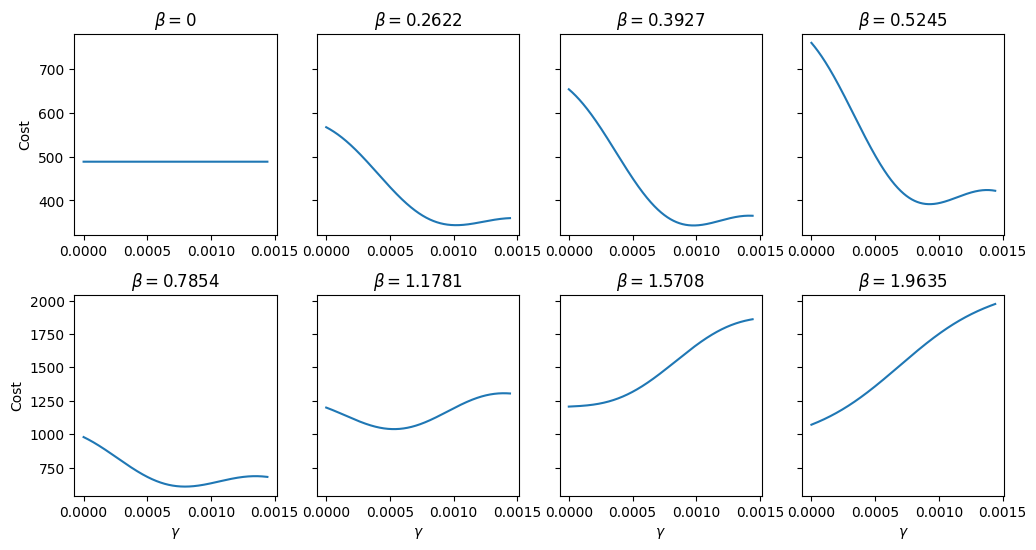

In [7]:
solver = QAOASolver(39, problem_hamiltonian='quadratic_H', cost_hamiltonian='quadratic_H')

# Max angle
max_gamma = 2*np.pi/max(solver.Ep)
print(max_gamma)

# Optimal angles for p=1
gamma_0 = 0.0004457756607718827
beta_0 = 0.5244786704891575

# Exploring angles for p=2
gammas = np.linspace(0, max_gamma, 10000)
betas = [0, beta_0/2, np.pi/8, beta_0, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8]

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey='row', sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost([gamma_0, gamma, beta_0, beta])
        cost.append(res)

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})

    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

### Experiment revision

In [8]:
experiment = 'N39_linear_quadratic_20250803114036088363'
p = 10
N = int(experiment.split('_')[0].removeprefix('N'))
setup = '_'.join(experiment.split('_')[1:-1])
solver = QAOASolver(
    N,
    problem_hamiltonian='quadratic_H' if setup=='standard' else 'linear_H',
    cost_hamiltonian='abs_H' if setup=='linear_abs' else 'quadratic_H'
)


df = pd.read_json(f'experiments/results/N{N}_{setup}/{experiment}.jsonl', lines=True)
df_layer = df[df['layers']==p].reset_index()
gammas_0 = df_layer.loc[0,'gammas']
betas_0 = df_layer.loc[0,'betas']

ValueError: Expected object or value

min_cost=37.99920319441613, opt_gamma=0.4898, opt_beta=0.0086


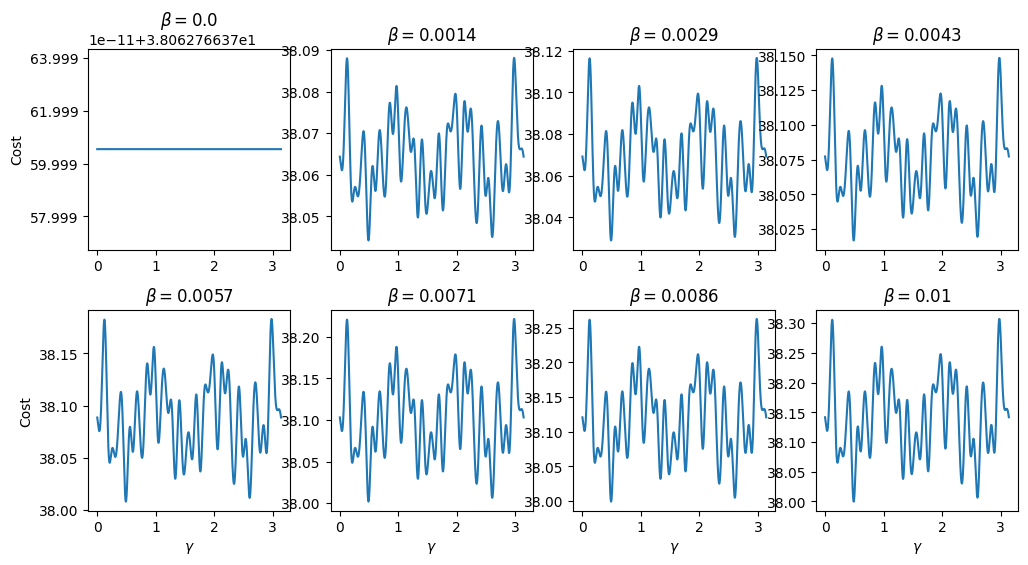

In [ ]:
# Exploring angles for p+1 layers
gammas = np.linspace(0, np.pi, 10000)
betas = np.linspace(0, 0.01, 8)

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey=False, sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

min_cost = 100
opt_gamma = 0
obt_beta = 0
for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost(gammas_0 + [gamma] + betas_0 + [beta])
        cost.append(res)

        if res < min_cost:
            min_cost = res
            opt_gamma = gamma
            opt_beta = beta

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})
    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

print(f'min_cost={min_cost}, opt_gamma={round(opt_gamma, 4)}, opt_beta={round(opt_beta, 4)}')

## Standard protocol

### N = 21

## N=21

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
80  21      BFGS       1    0.007     1.5  [0.008278311895312]   
70  21  L-BFGS-B       1    0.007     1.5  [0.008278311895116]   

                  betas       cost  fidelity  
80  [1.529769538903815]  32.774907  0.757476  
70  [1.529769538820518]  32.774907  0.757476

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
89  21      BFGS      10    0.007     1.5  5.701687e-22       1.0
79  21  L-BFGS-B      10    0.007     1.5  2.852285e-09       1.0

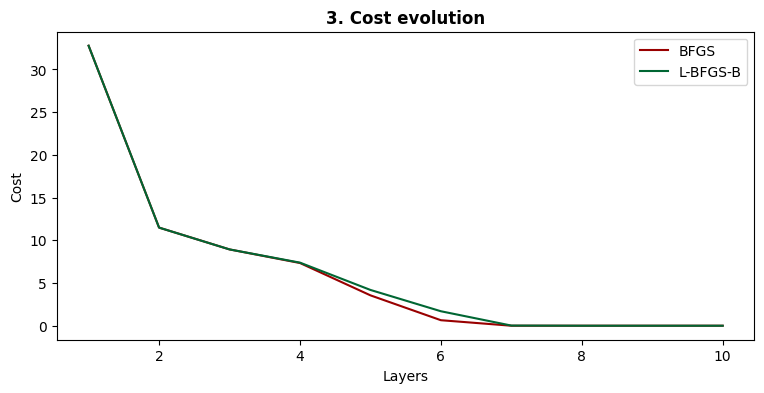

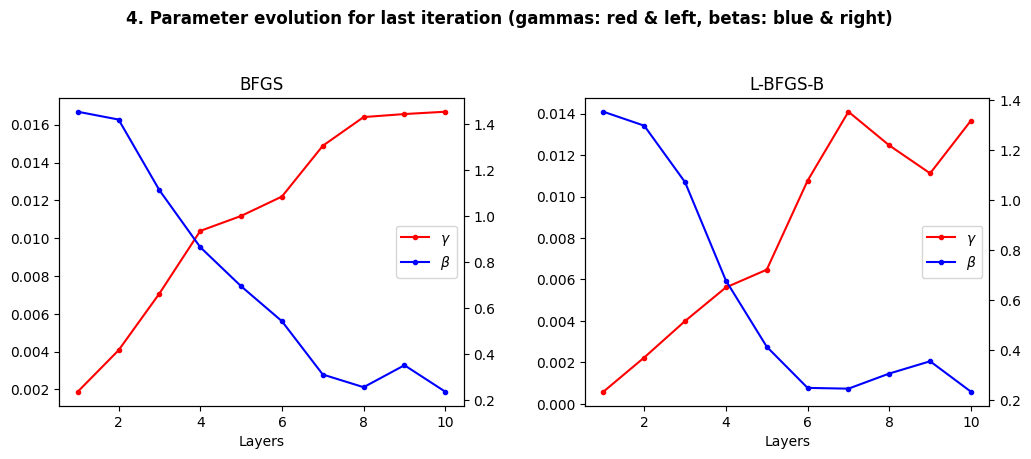

In [ ]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                    gammas  \
220  39      BFGS       1   0.0005     0.4       [0.000445775660771]   
190  39  L-BFGS-B       1   0.0005     0.4  [0.00044577565735500006]   

                    betas        cost  fidelity  
220  [0.5244786704891571]  488.233997  0.045932  
190   [0.524478674085292]  488.233997  0.045932

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
249  39      BFGS      30   0.0005     0.4   0.459909  0.977540
219  39  L-BFGS-B      30   0.0005     0.4  16.934879  0.338605

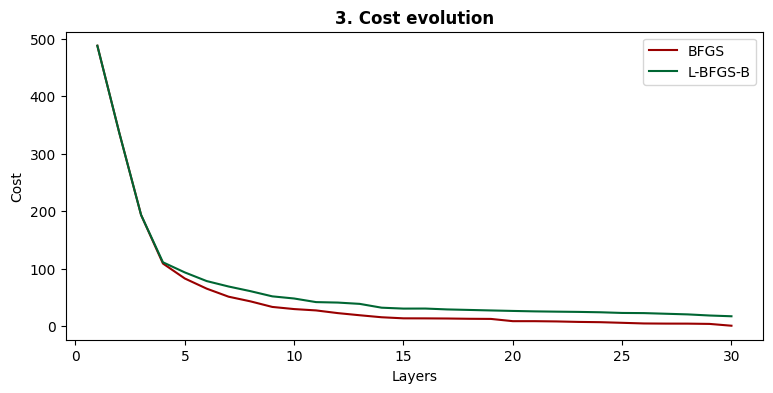

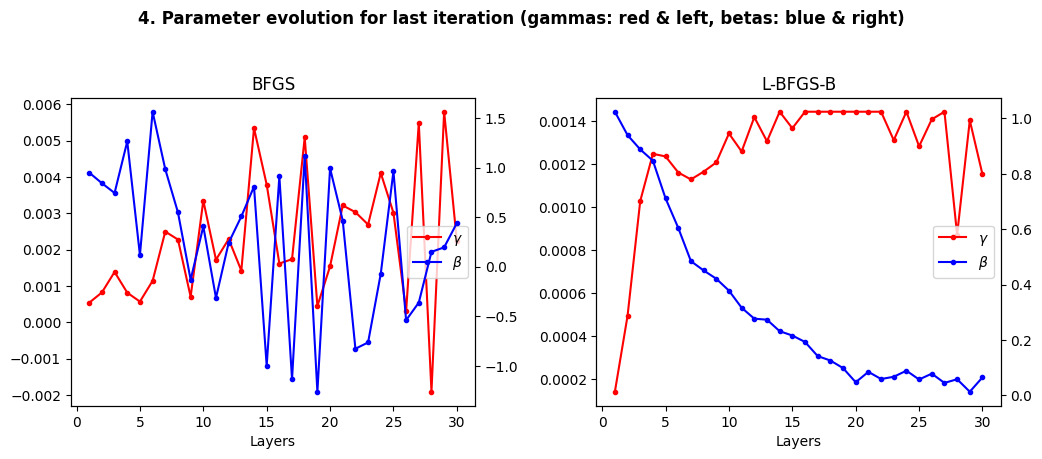

In [ ]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                   gammas  \
790  51      BFGS       1   0.0001     0.8  [7.653187295904522e-05]   
740  51  L-BFGS-B       1   0.0001     0.8    [7.6531872913161e-05]   

                    betas         cost  fidelity  
790  [0.6251993693818071]  1326.671435   0.02383  
740   [0.625199370602673]  1326.671435   0.02383

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
839  51      BFGS      50   0.0001     0.8  19.817432  0.299995
789  51  L-BFGS-B      50   0.0001     0.8  76.780489  0.155842

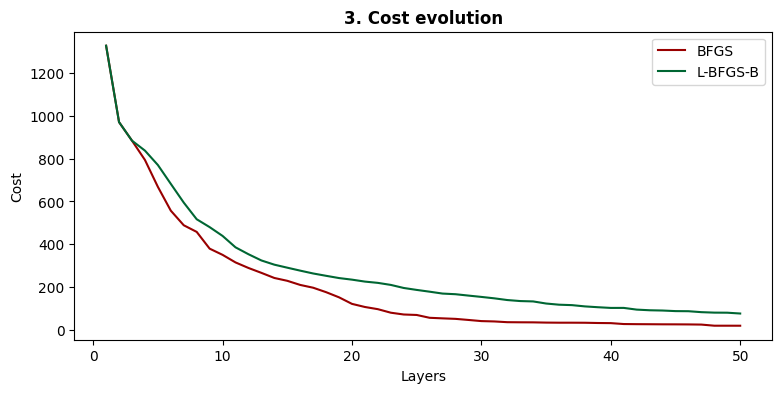

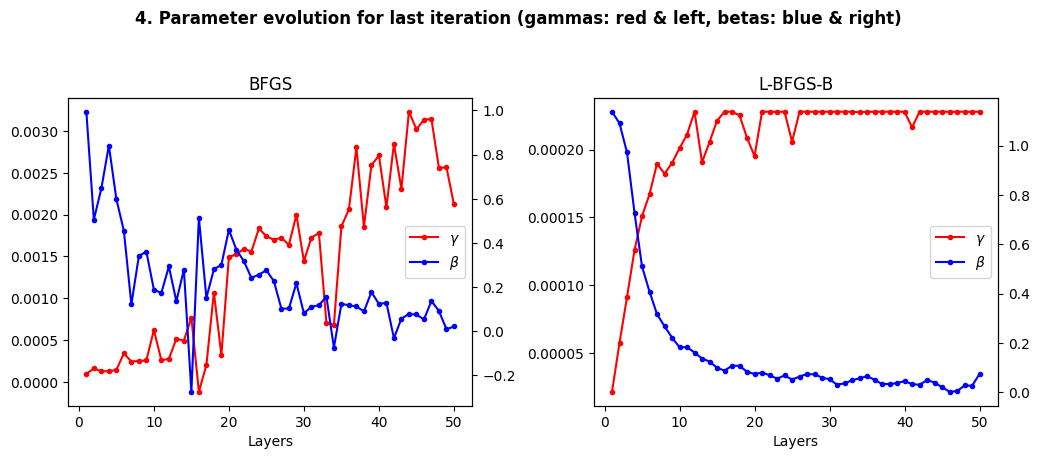

In [ ]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
1640  77      BFGS       1   0.0001    0.39  [0.000108307745618]   
1690  77  L-BFGS-B       1   0.0001    0.39  [0.000108307745781]   

                     betas         cost  fidelity  
1640  [0.5230479893037681]  1934.541313  0.022078  
1690   [0.523047988282447]  1934.541313  0.022078

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
1689  77      BFGS      50   0.0001    0.39   3.472893  0.707811
1739  77  L-BFGS-B      50   0.0001    0.39  56.238237  0.138790

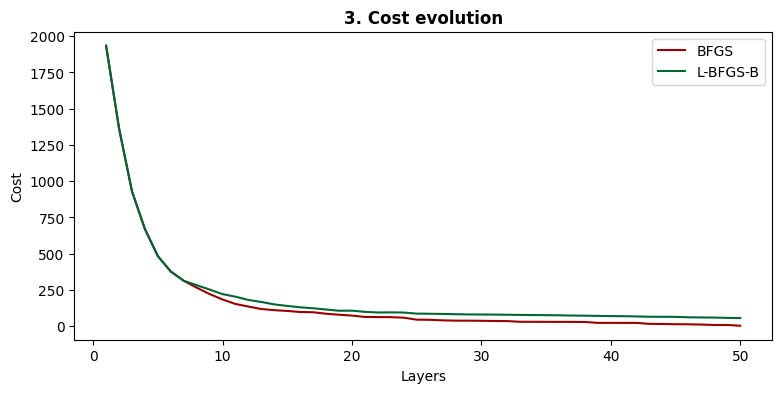

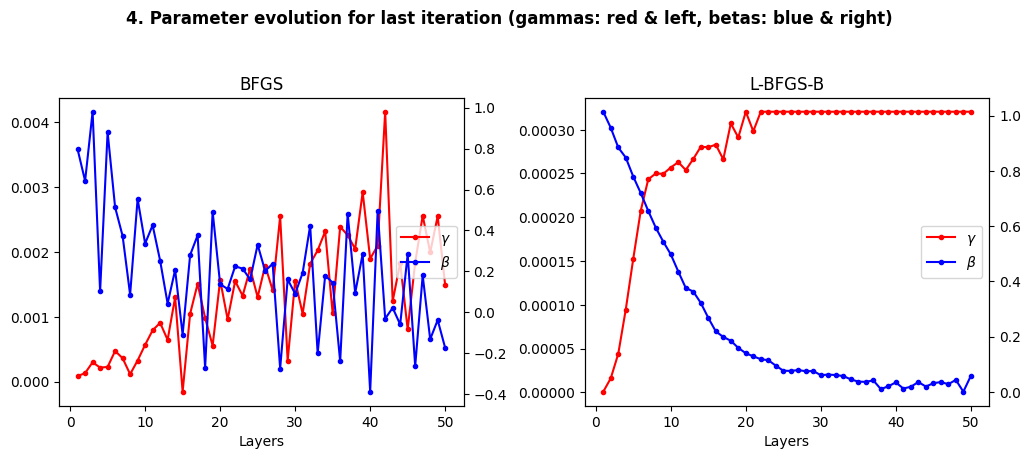

In [ ]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 87

## N=87

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                    gammas  \
1940  87      BFGS       1  0.00002     0.8  [1.7797972544527962e-05]   
1890  87  L-BFGS-B       1  0.00002     0.8    [1.77979722152876e-05]   

                     betas         cost  fidelity  
1940    [0.64937828388257]  5104.575317  0.009896  
1890  [0.6493783361282911]  5104.575317  0.009896

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
1989  87      BFGS      50  0.00002     0.8  202.545423  0.072133
1939  87  L-BFGS-B      50  0.00002     0.8  263.635548  0.044348

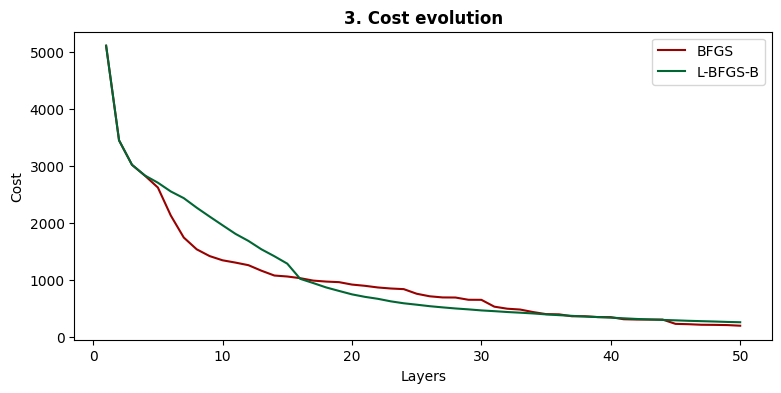

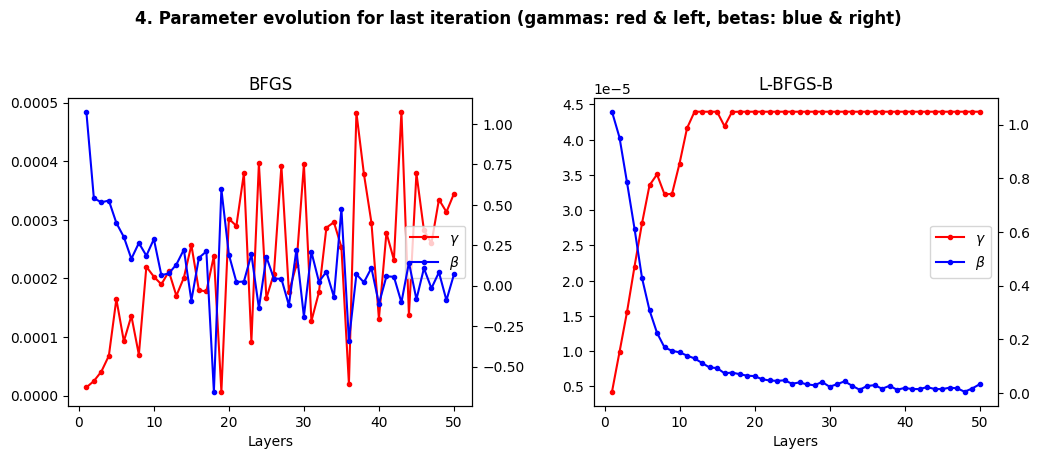

In [ ]:
N = 87

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 95

## N=95

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                   gammas  \
640  95      BFGS       1  0.00002     0.8  [1.826878524076459e-05]   
690  95  L-BFGS-B       1  0.00002     0.8  [1.826878518334806e-05]   

                    betas         cost  fidelity  
640  [0.6286191475733971]  5273.884037  0.011792  
690   [0.628619146302954]  5273.884037  0.011792

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
689  95      BFGS      50  0.00002     0.8  155.122925  0.081986
739  95  L-BFGS-B      50  0.00002     0.8  278.078724  0.047123

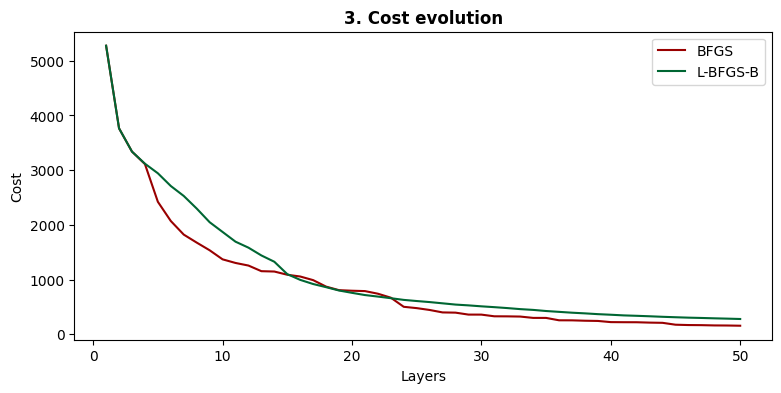

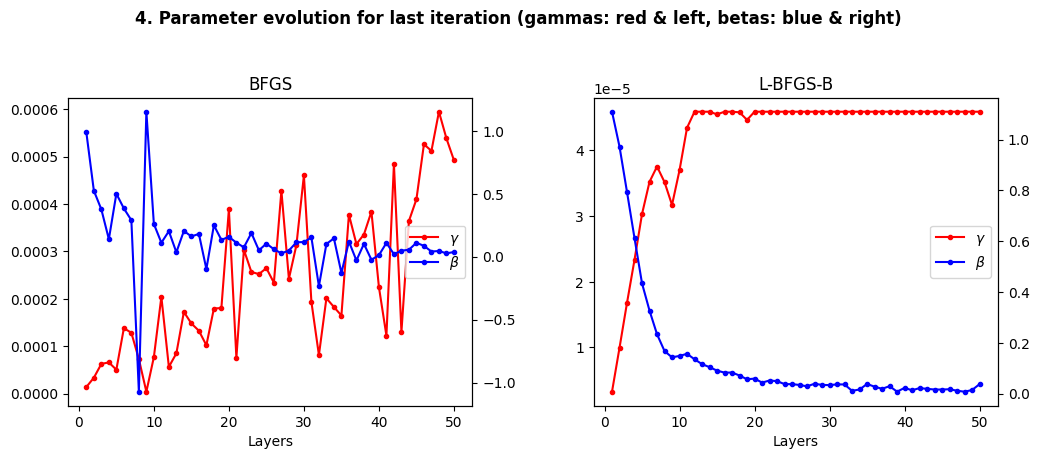

In [ ]:
N = 95

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 187

## N=187

**1. One layer QAOA**

N optimizer  layers   gamma_0  beta_0                    gammas  \
1100  187      BFGS       1  0.000005     0.8  [4.5403076430149606e-06]   
1030  187  L-BFGS-B       1  0.000005     0.8   [4.540307653729598e-06]   

                     betas          cost  fidelity  
1100  [0.6315139287467081]  20985.287486  0.005748  
1030   [0.631513914720741]  20985.287486  0.005748

**2. State at layers=70**

N optimizer  layers   gamma_0  beta_0         cost  fidelity
1169  187      BFGS      70  0.000005     0.8  1028.843785  0.041497
1099  187  L-BFGS-B      70  0.000005     0.8  1003.195907  0.025162

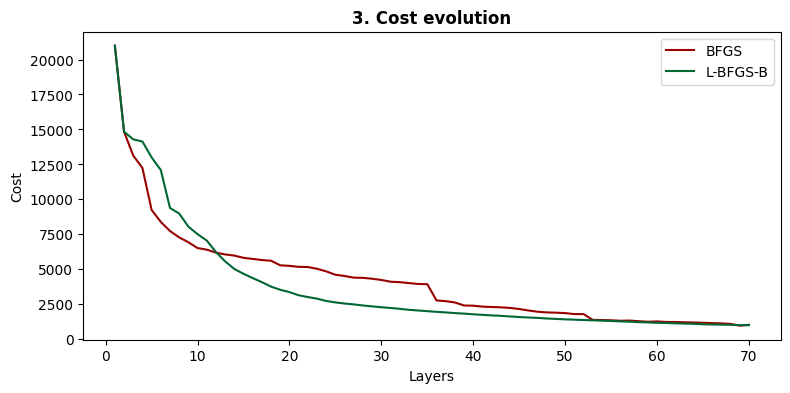

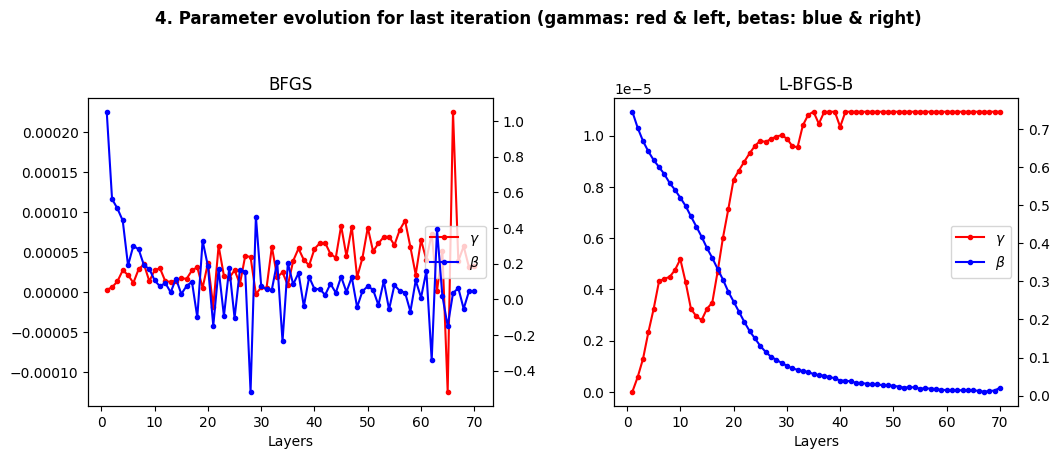

In [ ]:
N = 187

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Linear-quadratic protocol

### N = 21

## N=21

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                 gammas  \
800  21      BFGS       1     0.15     1.5    [0.154564850965925]   
790  21  L-BFGS-B       1     0.15     1.5  [0.15456485072714302]   

                    betas       cost  fidelity  
800  [1.5075920586575662]  74.357584  0.169938  
790   [1.507592055147221]  74.357584  0.169938

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
809  21      BFGS      10     0.15     1.5  1.943862e-19  1.000000
799  21  L-BFGS-B      10     0.15     1.5  3.862211e+01  0.130203

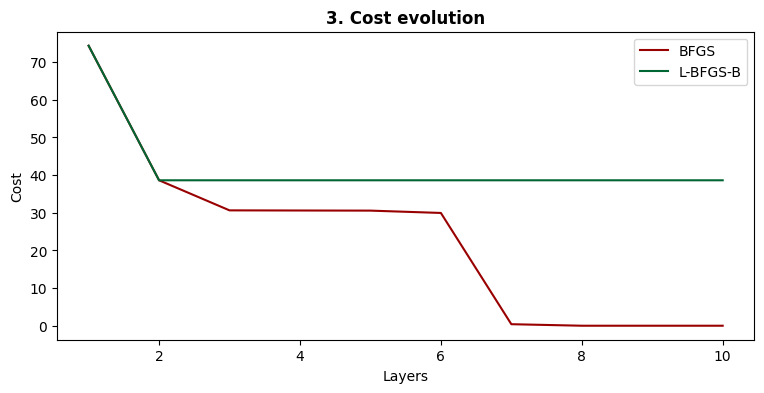

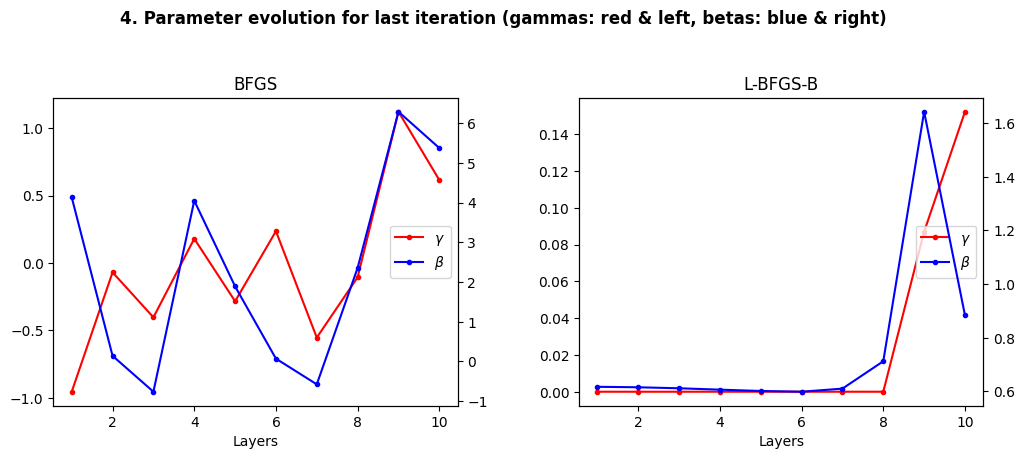

In [19]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
180  39      BFGS       1     0.05     1.5  [0.042419916569209]   
210  39  L-BFGS-B       1     0.05     1.5  [0.042419916719614]   

                   betas        cost  fidelity  
180   [1.46558428370015]  308.614459  0.046635  
210  [1.465584281583984]  308.614459  0.046635

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
209  39      BFGS      30     0.05     1.5    0.004596  0.999791
239  39  L-BFGS-B      30     0.05     1.5  129.967519  0.016010

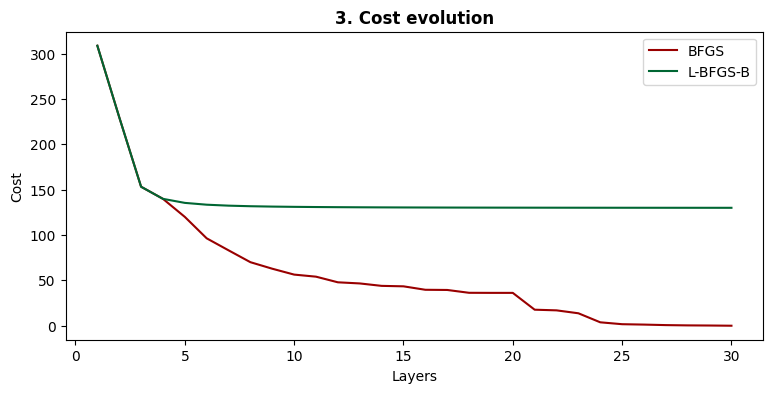

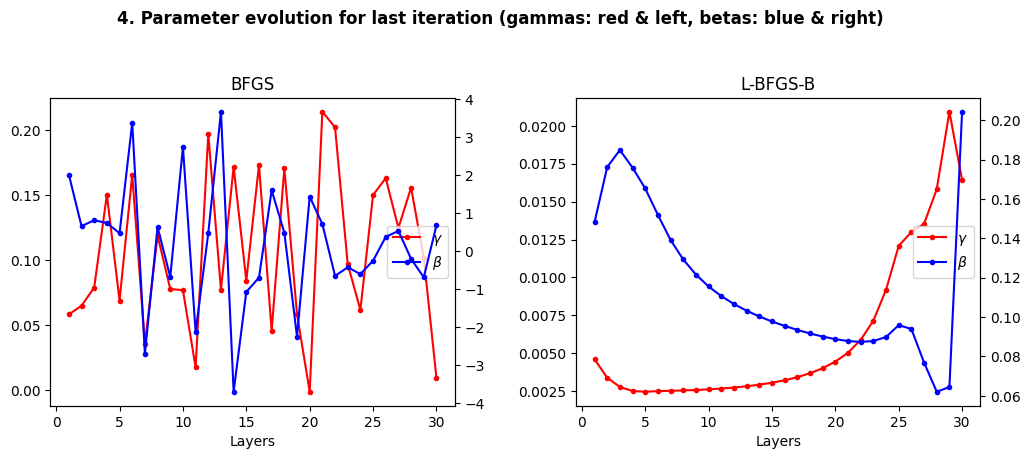

In [20]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
830  51      BFGS       1     0.01     1.1  [0.013172117193072002]   
880  51  L-BFGS-B       1     0.01     1.1  [0.013172117123907002]   

                   betas        cost  fidelity  
830  [1.071317677840412]  957.604456  0.012695  
880  [1.071317614553077]  957.604456  0.012695

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
879  51      BFGS      50     0.01     1.1   6.510248  0.008734
929  51  L-BFGS-B      50     0.01     1.1  66.013635  0.342925

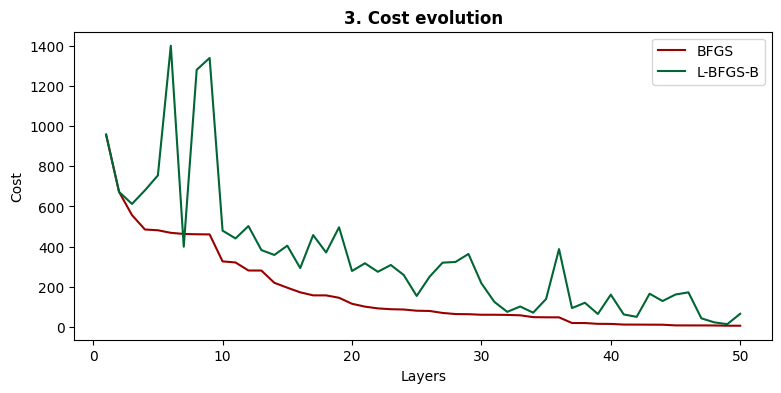

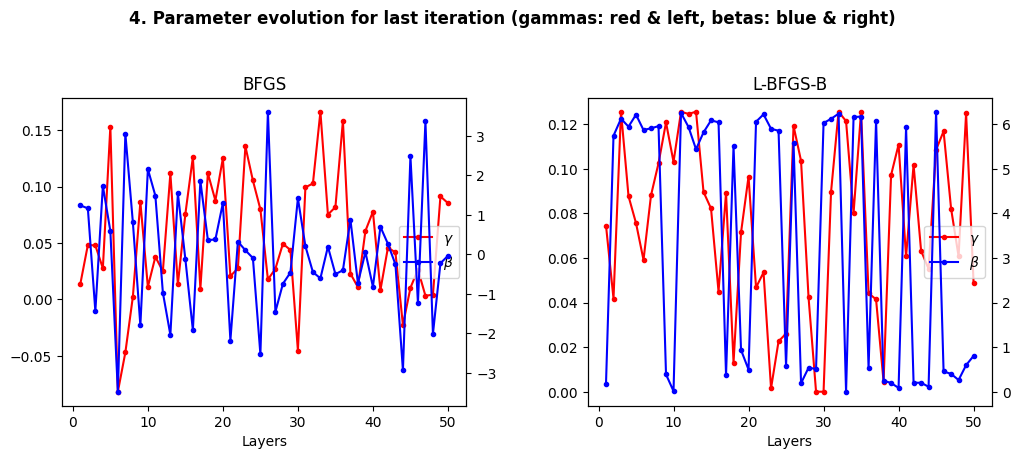

In [21]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
340  77      BFGS       1     0.05     2.3  [0.049794543256928]   
390  77  L-BFGS-B       1     0.05     2.3   [0.04979454330117]   

                   betas         cost  fidelity  
340  [2.270977840921084]  1382.099774  0.104663  
390  [2.270977842258782]  1382.099774  0.104663

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
389  77      BFGS      50     0.05     2.3    1.364976  0.934051
439  77  L-BFGS-B      50     0.05     2.3  194.919376  0.322893

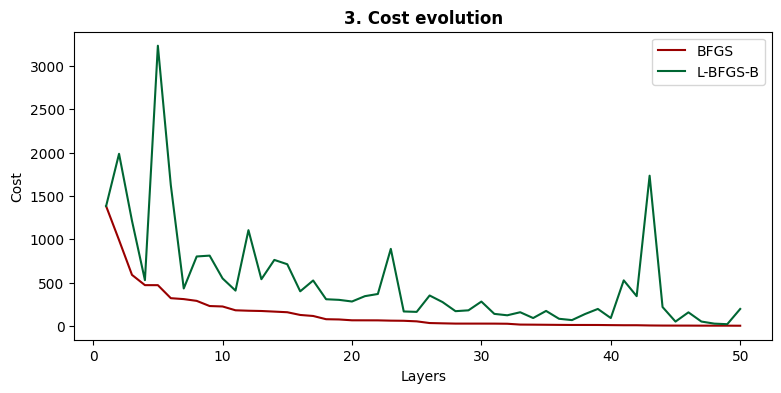

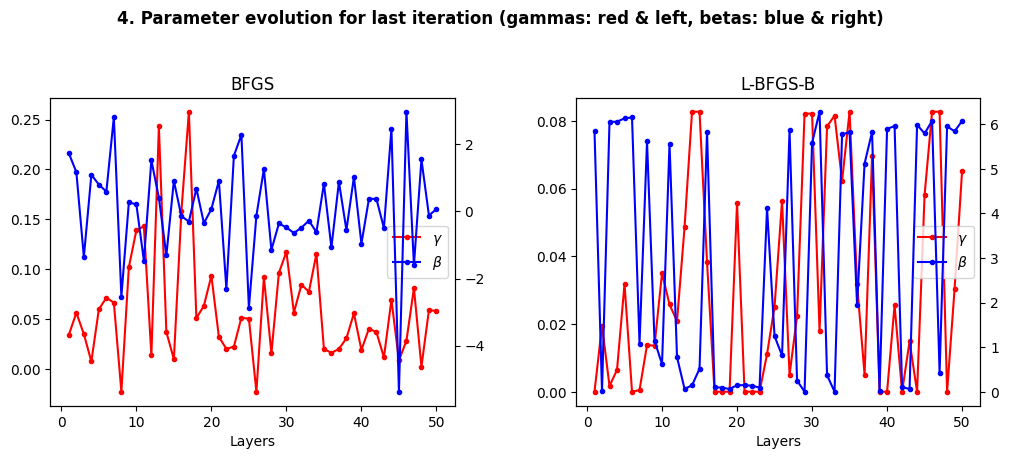

In [22]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 87

## N=87

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
290  87      BFGS       1     0.02     0.8  [0.021105579454695003]   
240  87  L-BFGS-B       1     0.02     0.8  [0.021105579455356002]   

                    betas         cost  fidelity  
290   [0.846775704930748]  4595.785424  0.029289  
240  [0.8467757047550181]  4595.785424  0.029289

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
339  87      BFGS      50     0.02     0.8  157.346934  0.409059
289  87  L-BFGS-B      50     0.02     0.8  116.587148  0.786320

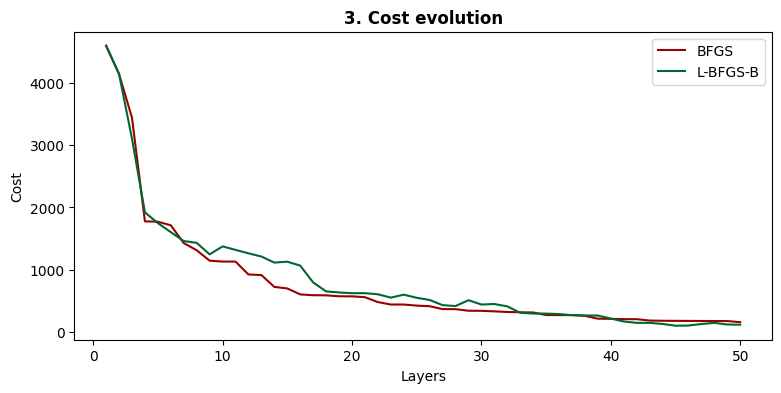

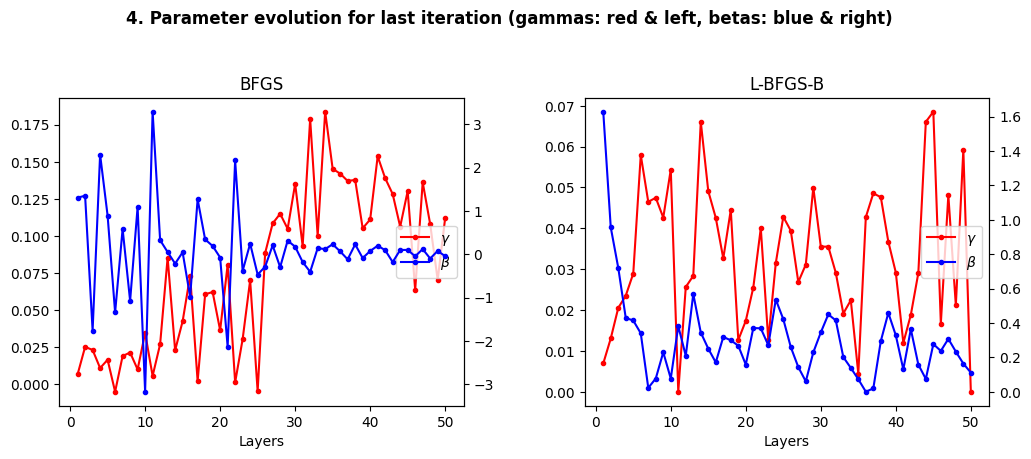

In [23]:
N = 87

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 95

## N=95

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
1330  95      BFGS       1  0.00002     0.8  [-0.38102473977994206]   
1280  95  L-BFGS-B       1  0.00002     0.8                   [0.0]   

                     betas          cost  fidelity  
1330  [1.6566699747106721]   5862.389439  0.017003  
1280                 [0.0]  13690.000000  0.007812

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
1379  95      BFGS      50  0.00002     0.8    283.906942  0.027451
1329  95  L-BFGS-B      50  0.00002     0.8  13690.000000  0.007812

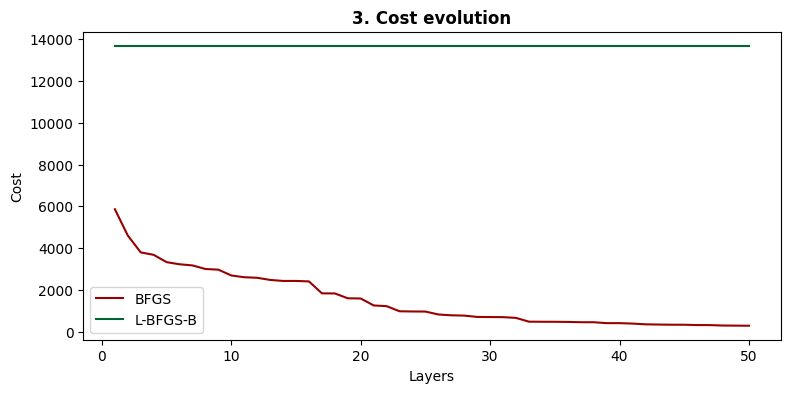

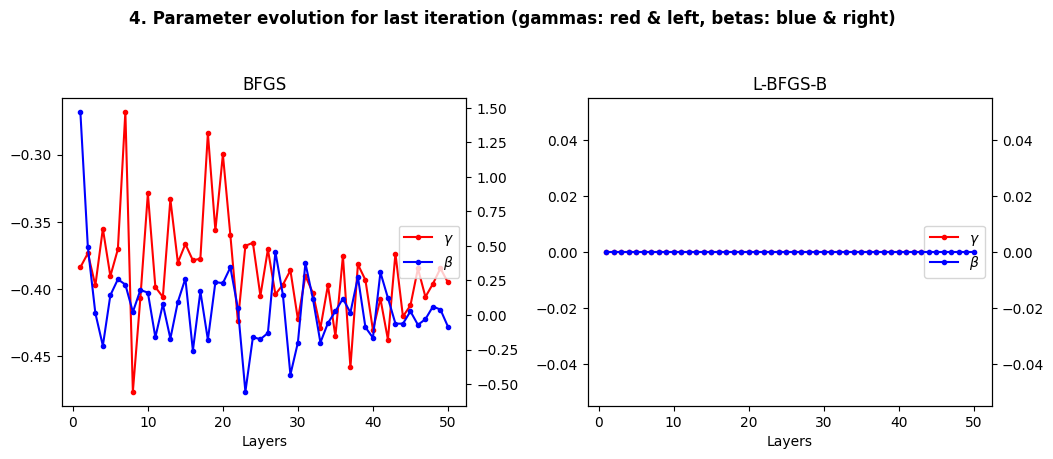

In [24]:
N = 95

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Linear-abs protocol

### N = 21

## N=21

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
1020  21      BFGS       1     0.15     1.5  [0.150167535914248]   
1010  21  L-BFGS-B       1     0.15     1.5  [0.150167529669819]   

                     betas      cost  fidelity  
1020  [1.4849625382688751]  6.808984  0.174848  
1010   [1.484962492110762]  6.808984  0.174848

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
1029  21      BFGS      10     0.15     1.5  1.570371e-17  1.000000
1019  21  L-BFGS-B      10     0.15     1.5  5.524890e+00  0.149457

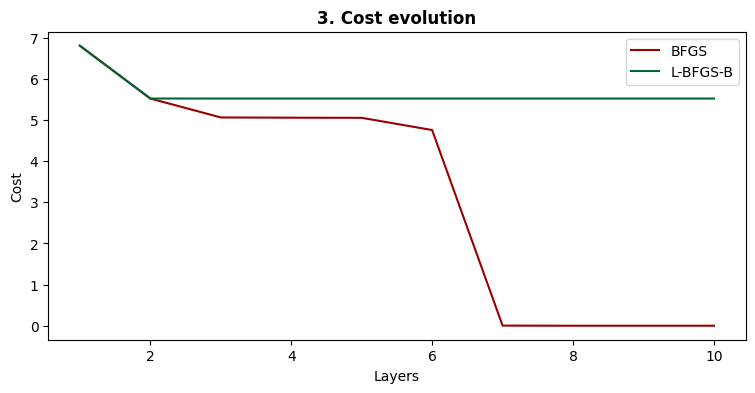

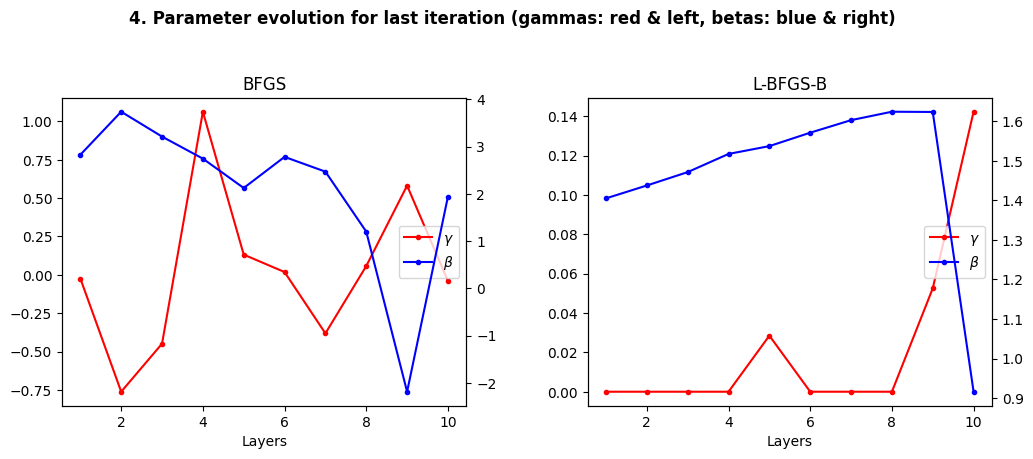

In [ ]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
2186  39      BFGS       1     0.05     1.5  [0.043914402413695]   
2246  39      BFGS       1     0.05     1.5  [0.043914402413695]   
2216  39  L-BFGS-B       1     0.05     1.5  [0.043914402411096]   

                    betas       cost  fidelity  
2186  [1.491486994085921]  13.621065  0.043982  
2246  [1.491486994085921]  13.621065  0.043982  
2216  [1.491486994120301]  13.621065  0.043982

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0      cost  fidelity
2215  39      BFGS      30     0.05     1.5  0.003014  0.999611
2275  39      BFGS      30     0.05     1.5  0.021208  0.997213
2245  39  L-BFGS-B      30     0.05     1.5  9.522119  0.016777

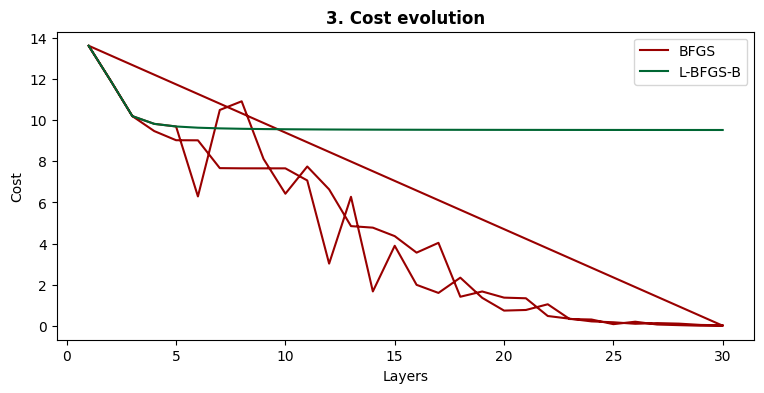

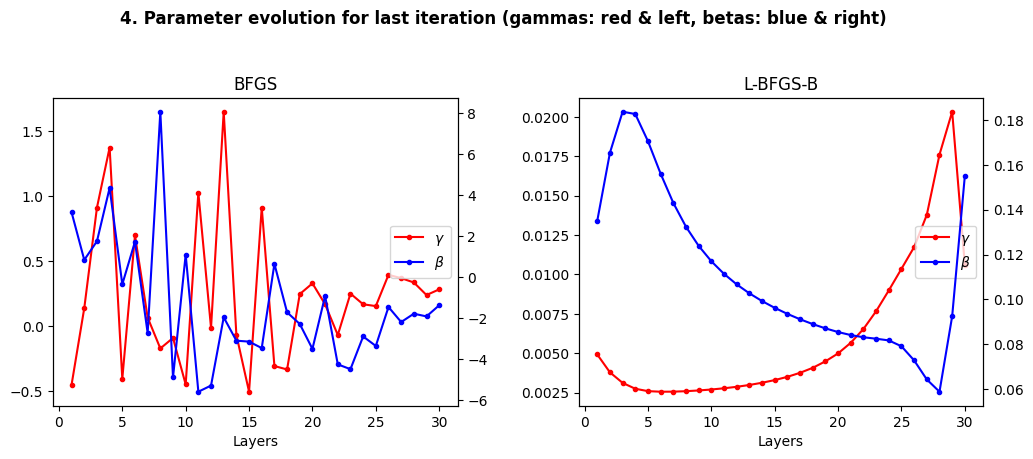

In [ ]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
1490  51      BFGS       1     0.01     1.1  [0.013849093690625001]   
1540  51      BFGS       1     0.01     1.1  [0.013849093690625001]   
1590  51  L-BFGS-B       1     0.01     1.1     [0.013849093798469]   

                    betas       cost  fidelity  
1490  [1.070235368618127]  27.227661  0.012325  
1540  [1.070235368618127]  27.227661  0.012325  
1590   [1.07023534830555]  27.227661  0.012325

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
1539  51      BFGS      50     0.01     1.1  20.480076  0.033494
1589  51      BFGS      50     0.01     1.1   0.246868  0.964455
1639  51  L-BFGS-B      50     0.01     1.1   0.586150  0.941289

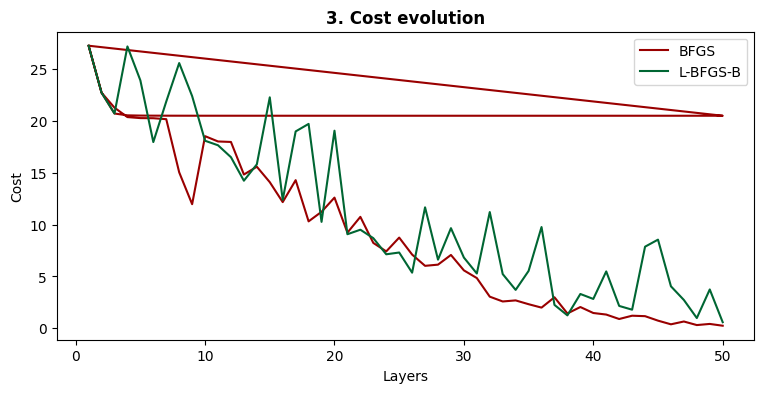

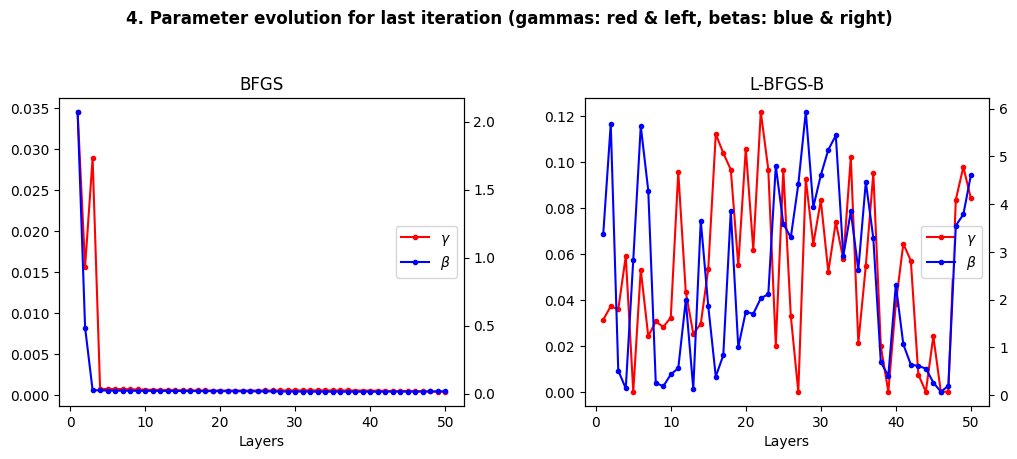

In [ ]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0  \
899  77      BFGS      10     0.05     2.3   
949  77      BFGS      10     0.05     2.3   
849  77  L-BFGS-B      10     0.05     2.3   

                                                gammas  \
899  [-0.018255623315996002, -0.741260440971749, -1...   
949  [0.740975157566358, -0.21855467223391903, 0.18...   
849  [0.082673490883941, 0.052757927992588, 0.03807...   

                                                 betas       cost  fidelity  
899  [1.905365483539109, 2.236028022982423, 0.79066...  16.283707  0.011391  
949  [4.16581383062505, 3.8198020194400693, 2.05438...  22.655123  0.082190  
849  [4.476979597086492, 0.8561116615627371, 1.3254...  18.015488  0.393681

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0      cost  fidelity
939  77      BFGS      50     0.05     2.3  0.178236  0.975117
989  77      BFGS      50     0.05     2.3  0.349035  0.943610
889  77  L-BFGS-B      50     0.05     2.3  2.295686  0.715756

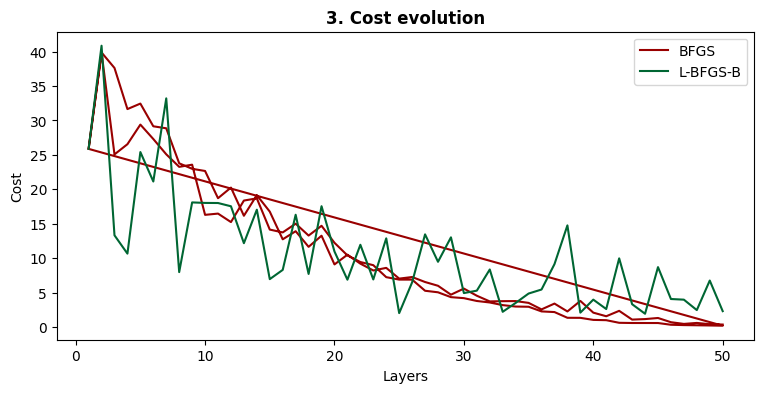

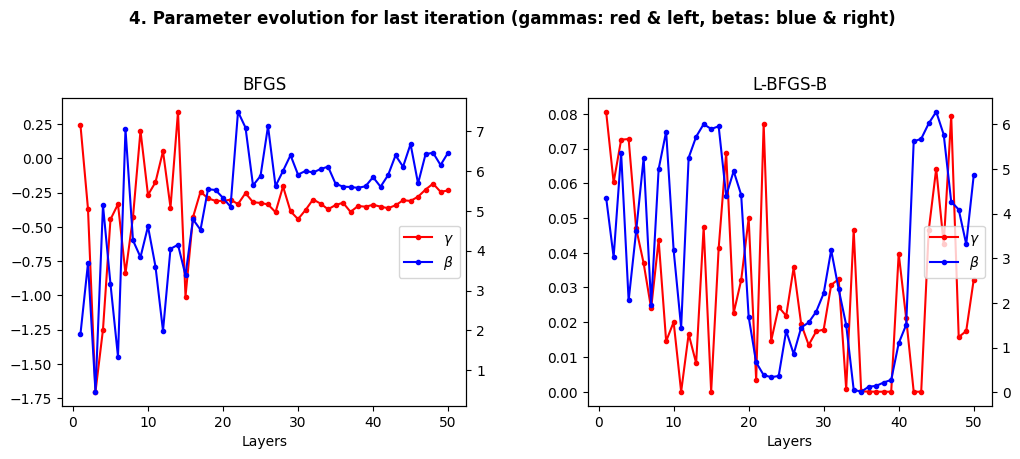

In [ ]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==10][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Comparison standard (unbounded) vs linear (unbounded)

### N = 21

## N=21

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0               gammas  \
1020  21        linear_abs       1    0.150     1.5  [0.150167535914248]   
1000  21  linear_quadratic       1    0.150     1.5  [0.154564850965925]   
80    21          standard       1    0.007     1.5  [0.008278311895312]   

                     betas       cost  fidelity  
1020  [1.4849625382688751]   6.808984  0.174848  
1000  [1.5075920586575662]  74.357584  0.169938  
80     [1.529769538903815]  32.774907  0.757476

**2. State at layers=10**

N             setup  layers  gamma_0  beta_0          cost  fidelity
1029  21        linear_abs      10    0.150     1.5  1.570371e-17       1.0
1009  21  linear_quadratic      10    0.150     1.5  1.943862e-19       1.0
89    21          standard      10    0.007     1.5  5.701687e-22       1.0

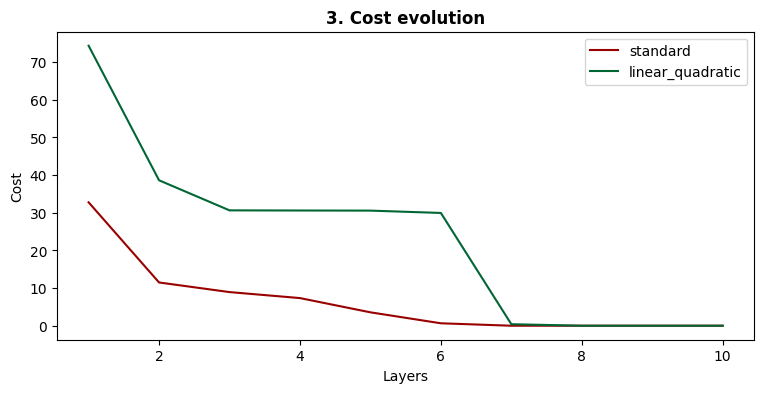

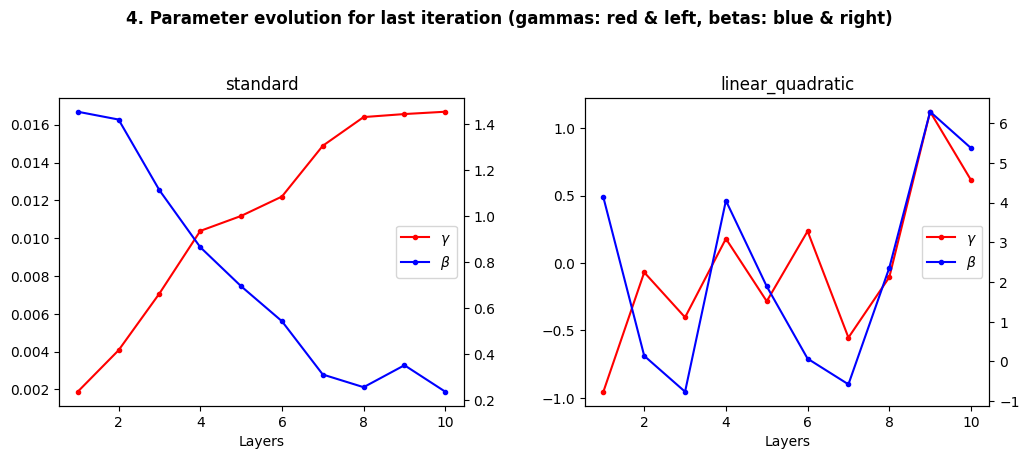

In [ ]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0               gammas  \
2186  39        linear_abs       1   0.0500     1.5  [0.043914402413695]   
2246  39        linear_abs       1   0.0500     1.5  [0.043914402413695]   
250   39  linear_quadratic       1   0.0500     1.5  [0.042419916569209]   
280   39  linear_quadratic       1   0.0500     1.5  [0.042419916569209]   
220   39          standard       1   0.0005     0.4  [0.000445775660771]   

                     betas        cost  fidelity  
2186   [1.491486994085921]   13.621065  0.043982  
2246   [1.491486994085921]   13.621065  0.043982  
250     [1.46558428370015]  308.614459  0.046635  
280     [1.46558428370015]  308.614459  0.046635  
220   [0.5244786704891571]  488.233997  0.045932

**2. State at layers=30**

N             setup  layers  gamma_0  beta_0      cost  fidelity
2215  39        linear_abs      30   0.0500     1.5  0.003014  0.999611
2275  39        linear_abs      30   0.0500     1.5  0.021208  0.997213
279   39  linear_quadratic      30   0.0500     1.5  0.004596  0.999791
309   39  linear_quadratic      30   0.0500     1.5  0.128953  0.994650
249   39          standard      30   0.0005     0.4  0.459909  0.977540

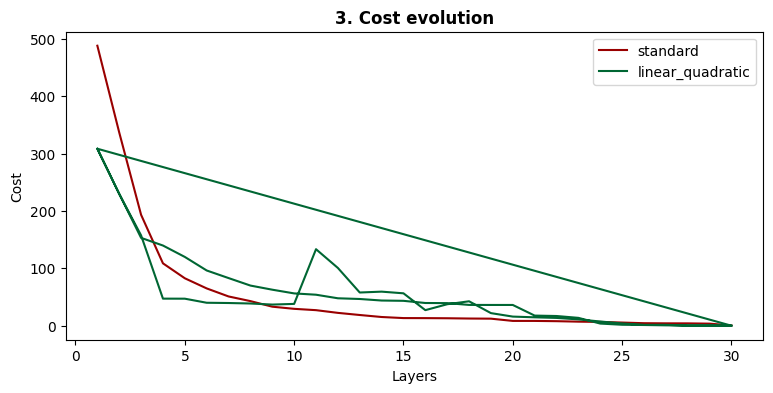

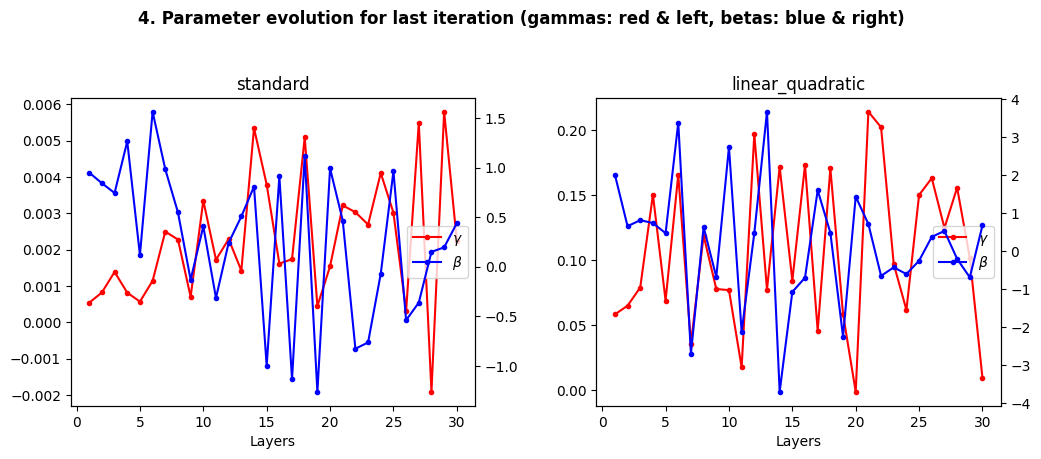

In [ ]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0                   gammas  \
1490  51        linear_abs       1   0.0100     1.1   [0.013849093690625001]   
1540  51        linear_abs       1   0.0100     1.1   [0.013849093690625001]   
1240  51  linear_quadratic       1   0.0100     1.1   [0.013172117193072002]   
1290  51  linear_quadratic       1   0.0100     1.1   [0.013172117193072002]   
790   51          standard       1   0.0001     0.8  [7.653187295904522e-05]   

                     betas         cost  fidelity  
1490   [1.070235368618127]    27.227661  0.012325  
1540   [1.070235368618127]    27.227661  0.012325  
1240   [1.071317677840412]   957.604456  0.012695  
1290   [1.071317677840412]   957.604456  0.012695  
790   [0.6251993693818071]  1326.671435  0.023830

**2. State at layers=50**

N             setup  layers  gamma_0  beta_0       cost  fidelity
1539  51        linear_abs      50   0.0100     1.1  20.480076  0.033494
1589  51        linear_abs      50   0.0100     1.1   0.246868  0.964455
1289  51  linear_quadratic      50   0.0100     1.1   6.510248  0.008734
1339  51  linear_quadratic      50   0.0100     1.1   9.396726  0.067984
839   51          standard      50   0.0001     0.8  19.817432  0.299995

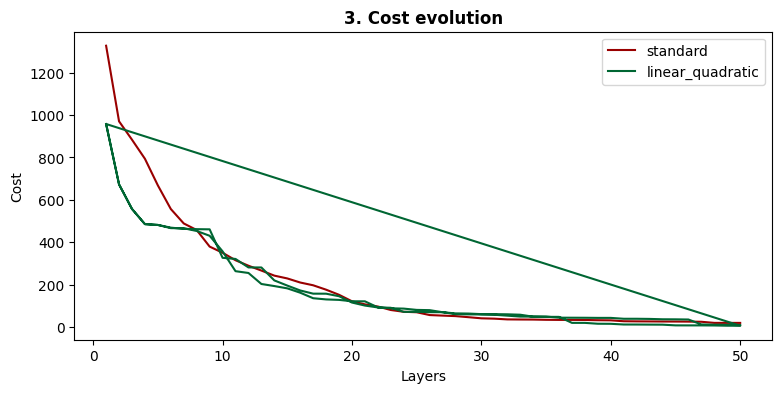

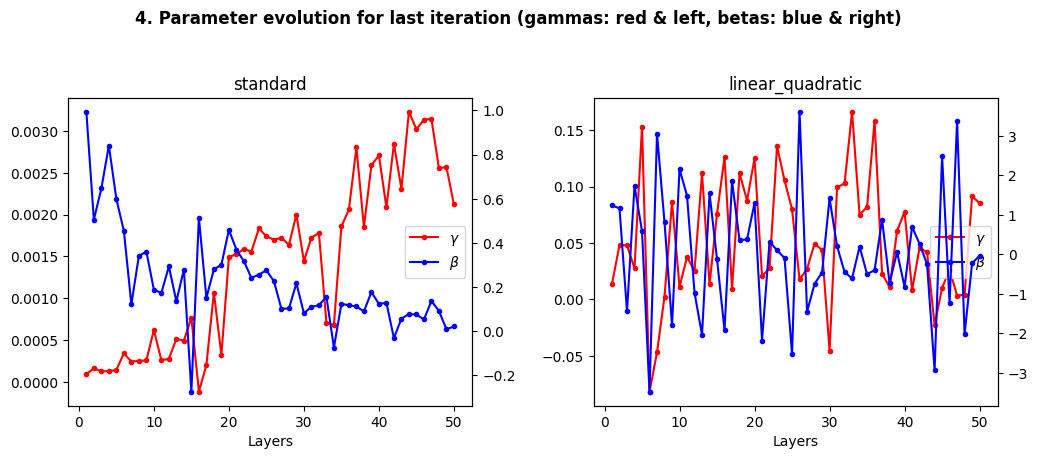

In [ ]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0                  gammas  \
890   77        linear_abs       1   0.0500    2.30  [0.049438310407823004]   
940   77        linear_abs       1   0.0500    2.30  [0.049438310407823004]   
490   77  linear_quadratic       1   0.0500    2.30     [0.049794543256928]   
590   77  linear_quadratic       1   0.0500    2.30     [0.049794543256928]   
1640  77          standard       1   0.0001    0.39     [0.000108307745618]   

                     betas         cost  fidelity  
890    [2.219804708201128]    25.867042  0.108715  
940    [2.219804708201128]    25.867042  0.108715  
490    [2.270977840921084]  1382.099774  0.104663  
590    [2.270977840921084]  1382.099774  0.104663  
1640  [0.5230479893037681]  1934.541313  0.022078

**2. State at layers=50**

N             setup  layers  gamma_0  beta_0       cost  fidelity
939   77        linear_abs      50   0.0500    2.30   0.178236  0.975117
989   77        linear_abs      50   0.0500    2.30   0.349035  0.943610
539   77  linear_quadratic      50   0.0500    2.30   1.364976  0.934051
639   77  linear_quadratic      50   0.0500    2.30  10.099988  0.106138
1689  77          standard      50   0.0001    0.39   3.472893  0.707811

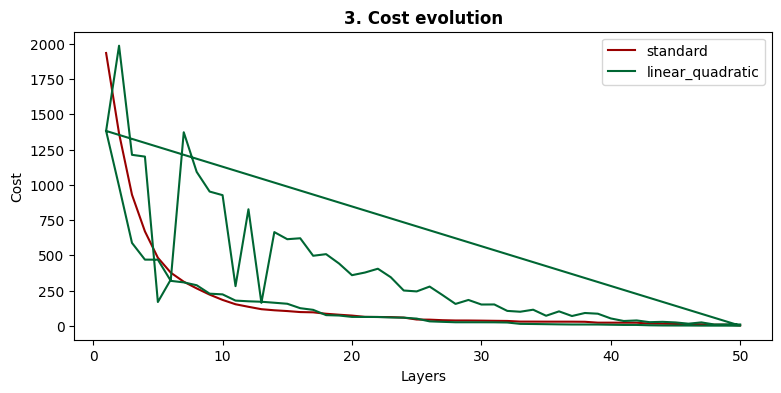

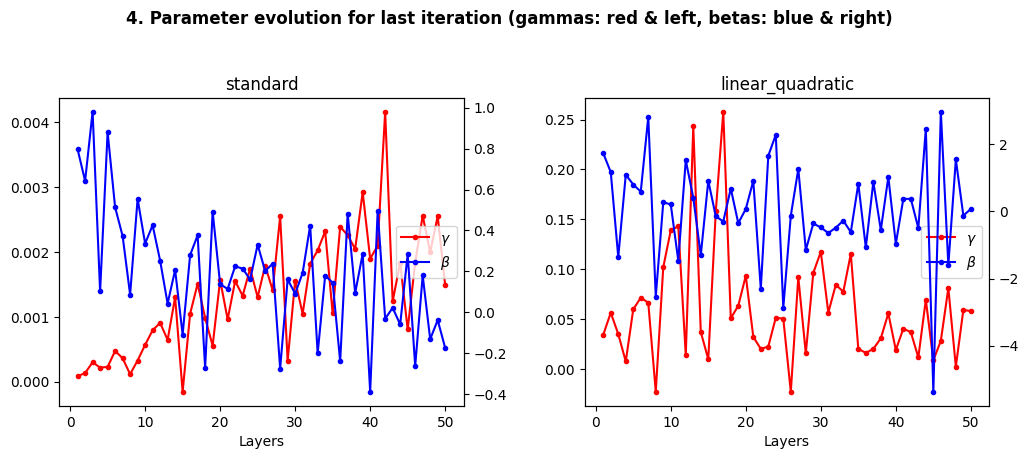

In [ ]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Summary

In [ ]:
df = experiment_results[(experiment_results['N'].isin([21,39,51,77]))]
df = df[df['layers']==df['N'].map({21: 10, 39: 30, 51: 50, 77: 50})]
df = df[['N', 'num_qubits','optimizer', 'setup', 'max_layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']]
df = df.rename(columns={'setup': 'protocol'})
pivot = df.pivot_table(values=['cost', 'fidelity'], index=['N'], columns=['protocol', 'optimizer'])
pivot.columns = pivot.columns.reorder_levels(['protocol', 'optimizer', None])
pivot = pivot.sort_index(axis=1, level=[0,1,2], ascending=[False, False, True])

pivot

protocol       standard                                   linear_quadratic  \
optimizer      L-BFGS-B                    BFGS                   L-BFGS-B   
                   cost  fidelity          cost  fidelity             cost   
N                                                                            
21         2.852285e-09  1.000000  5.701687e-22  1.000000        38.622113   
39         1.693488e+01  0.338605  4.599092e-01  0.977540       129.967519   
51         7.678049e+01  0.155842  1.981743e+01  0.299995        66.013635   
77         5.623824e+01  0.138790  3.472893e+00  0.707811       194.919376   

protocol                                    linear_abs            \
optimizer                    BFGS             L-BFGS-B             
           fidelity          cost  fidelity       cost  fidelity   
N                                                                  
21         0.130203  1.943862e-19  1.000000   5.524890  0.149457   
39         0.016010  6.677430e-02  0.997220   9.522119  0.016777   
51         0.342925  7.953487e+00  0.038359   0.586150  0.941289   
77         0.322893  5.732482e+00  0.520095   2.295686  0.715756   

protocol                           
optimizer          BFGS            
                   cost  fidelity  
N                                  
21         1.570371e-17  1.000000  
39         1.211106e-02  0.998412  
51         1.036347e+01  0.498974  
77         2.636355e-01  0.959363

In [ ]:
df = experiment_results[(experiment_results['N'].isin([21,39,51,77])) & (experiment_results['setup']=='linear_abs')]
df = df[df['layers']==df['N'].map({21: 10, 39: 30, 51: 50, 77: 50})]
df = df[['N', 'layers', 'num_qubits','optimizer', 'setup', 'max_layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']]
df = df.rename(columns={'setup': 'protocol'})
pivot = df.pivot_table(values=['cost', 'fidelity'], index=['N', 'layers'], columns=['optimizer'])
pivot.columns = pivot.columns.reorder_levels(['optimizer', None])
pivot = pivot.sort_index(axis=1, level=[0,1], ascending=[False, True])

pivot

optimizer  L-BFGS-B                    BFGS          
               cost  fidelity          cost  fidelity
N  layers                                            
21 10      5.524890  0.149457  1.570371e-17  1.000000
39 30      9.522119  0.016777  1.211106e-02  0.998412
51 50      0.586150  0.941289  1.036347e+01  0.498974
77 50      2.295686  0.715756  2.636355e-01  0.959363

## Extras

### Fidelity plots

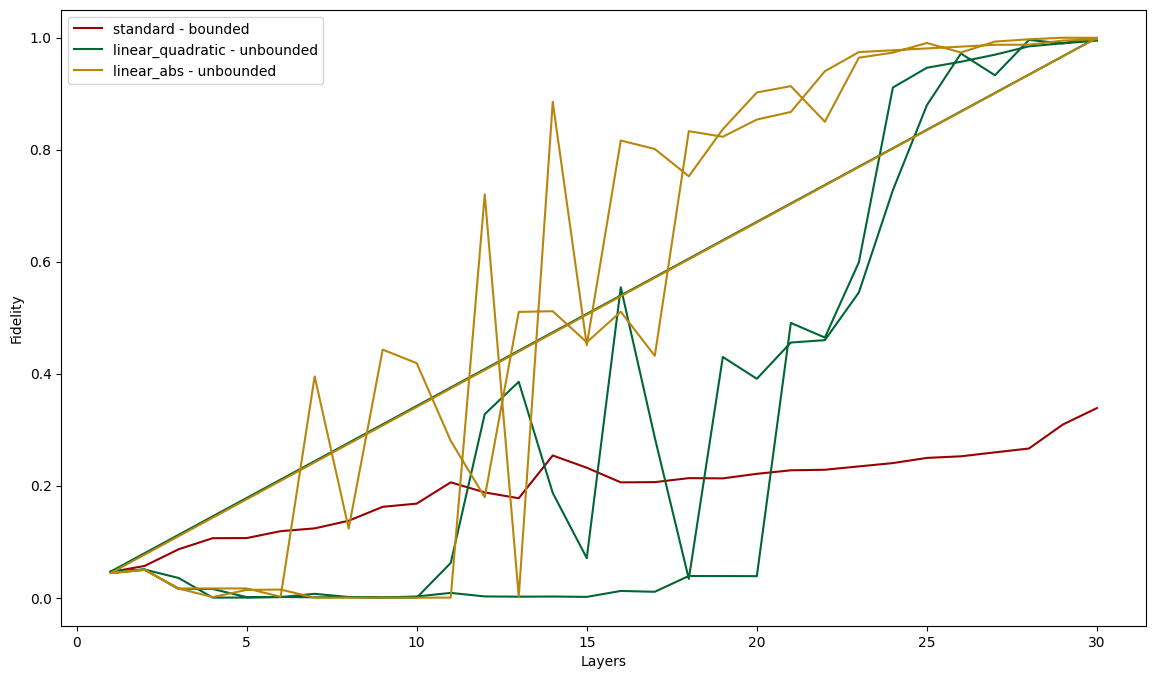

In [ ]:
N = 39

df = experiment_results[(experiment_results['N']==N) & (experiment_results['layers']<=30)]

opt_map = {'L-BFGS-B': 'bounded', 'BFGS': 'unbounded'}

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
for i in range(3):
    if i==0:
        setup = 'standard'
        optimizer = 'L-BFGS-B'
    if i==1:
        setup = 'linear_quadratic'
        optimizer = 'BFGS'
    if i==2:
        setup = 'linear_abs'
        optimizer = 'BFGS'
    df_i = df[(df['setup']==setup) & (df['optimizer']==optimizer)]
    ax.plot('layers', 'fidelity', data=df_i, color=plot_colors[i+2][0], label=f'{setup} - {opt_map[optimizer]}')
ax.set_xlabel('Layers')
ax.set_ylabel('Fidelity')
ax.legend();

### Probability distributions

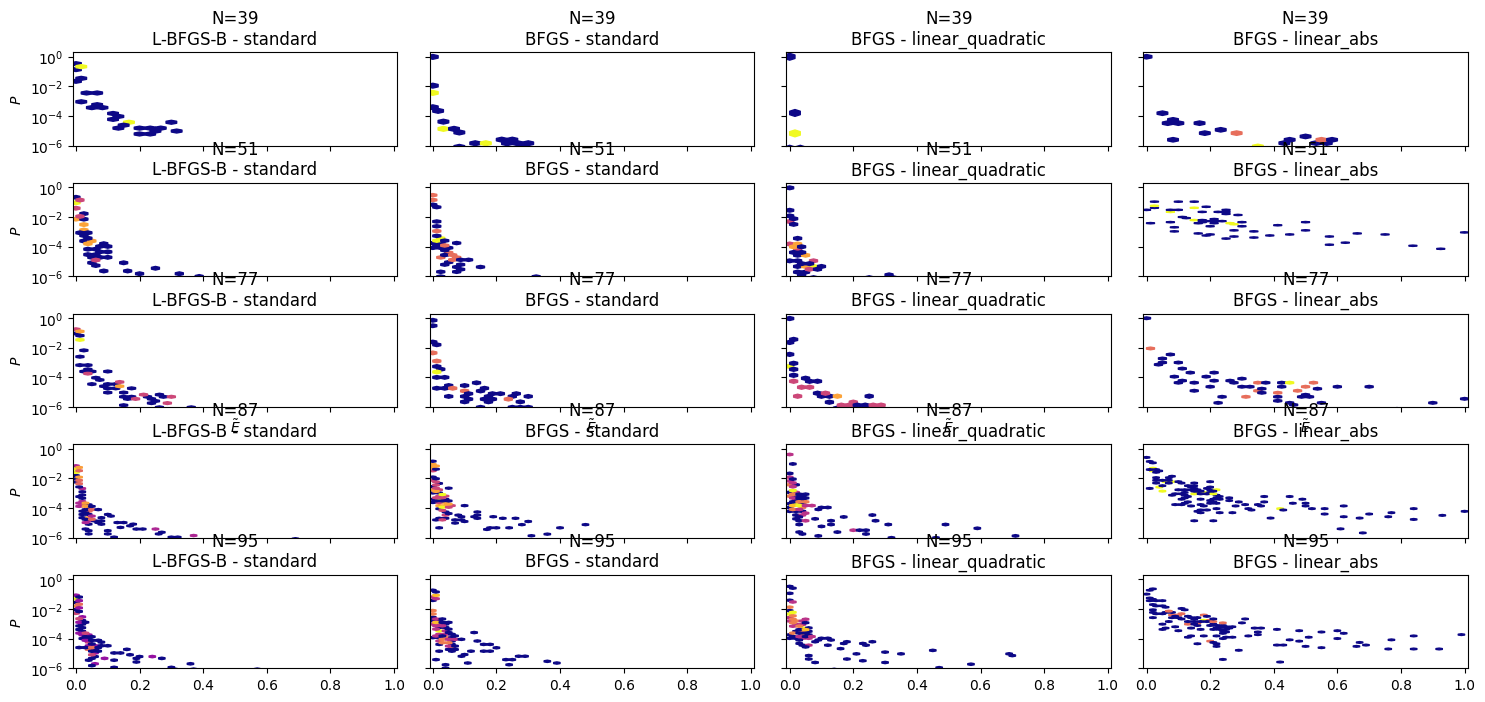

In [25]:
Ns = [39,51,77,87,95]
layers_map = {21: 10, 39: 30, 51: 50, 77: 50, 87:50, 95:50}
gridsize_map = {39: 30, 51: 40, 77:40, 87: 50, 95: 50}

df = experiment_results[(experiment_results['N'].isin(Ns))]
df = df[df['layers']==df['N'].map(layers_map)]

fig, axs = plt.subplots(nrows=len(Ns), ncols=4, figsize=(18,8), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, N in enumerate(Ns):
    for j in range(4):
        if j==0:
            optimizer = 'L-BFGS-B'
            setup = 'standard'
        elif j==1:
            optimizer = 'BFGS'
            setup = 'standard'
        elif j==2:
            optimizer = 'BFGS'
            setup = 'linear_quadratic'
        elif j==3:
            optimizer = 'BFGS'
            setup = 'linear_abs'
        
        df_s = df[(df['N']==N) & (df['optimizer']==optimizer) & (df['setup']==setup)].reset_index(drop=True)
            
        ax = axs[i][j]

        probs = df_s.loc[0,'state_populations']
        energies = np.array(df_s.loc[0,'Ec'])
        layer_max = df_s.loc[0, 'layers']

        E_min = np.min(energies)
        E_max = np.max(energies)
        rescaled_E = (energies - E_min) / (E_max - E_min)
        

        hb = ax.hexbin(rescaled_E, probs, gridsize=gridsize_map[N], cmap='plasma', bins='log', yscale='log')
        ax.set_title(f"N={N}\n{optimizer} - {setup}")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,2)
        if j == 0:
            ax.set_ylabel('$P$')
        if i == 2:
            ax.set_xlabel('$\\tilde{E}$')

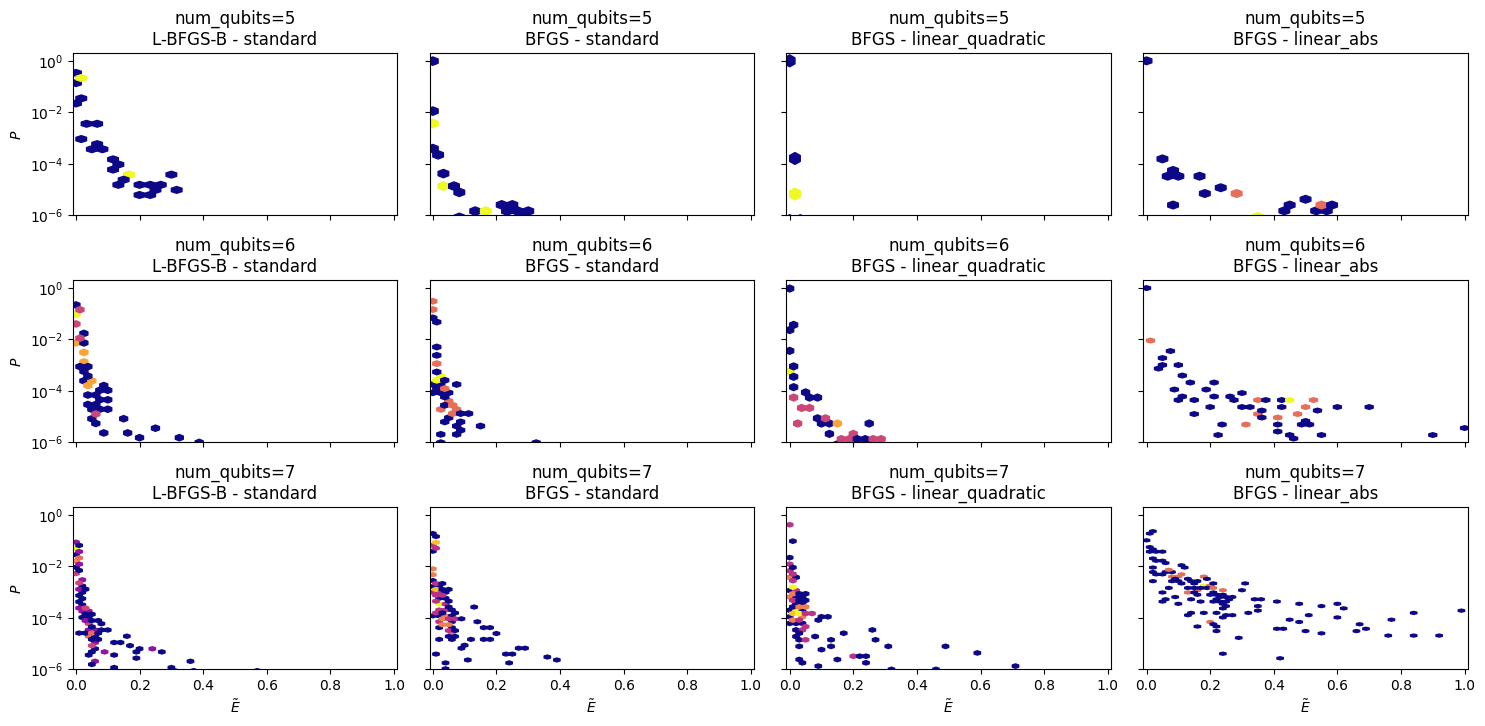

In [26]:
Ns = [39,51,77,87,95]
layers_map = {21: 10, 39: 30, 51: 50, 77: 50, 87:50, 95:50}
gridsize_map = {5: 30, 6: 40, 7: 50}

df = experiment_results[(experiment_results['N'].isin(Ns))]
df = df[df['layers']==df['N'].map(layers_map)]

ns = sorted(df['num_qubits'].unique())

fig, axs = plt.subplots(nrows=len(ns), ncols=4, figsize=(18,8), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, n in enumerate(ns):
    for j in range(4):
        if j==0:
            optimizer = 'L-BFGS-B'
            setup = 'standard'
        elif j==1:
            optimizer = 'BFGS'
            setup = 'standard'
        elif j==2:
            optimizer = 'BFGS'
            setup = 'linear_quadratic'
        elif j==3:
            optimizer = 'BFGS'
            setup = 'linear_abs'
        
        df_s = df[(df['num_qubits']==n) & (df['optimizer']==optimizer) & (df['setup']==setup)].reset_index(drop=True)
            
        ax = axs[i][j]

        probs = df_s.loc[0,'state_populations']
        energies = np.array(df_s.loc[0,'Ec'])
        layer_max = df_s.loc[0, 'layers']

        E_min = np.min(energies)
        E_max = np.max(energies)
        rescaled_E = (energies - E_min) / (E_max - E_min)
        

        hb = ax.hexbin(rescaled_E, probs, gridsize=gridsize_map[n], cmap='plasma', bins='log', yscale='log')
        ax.set_title(f"num_qubits={n}\n{optimizer} - {setup}")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,2)
        if j == 0:
            ax.set_ylabel('$P$')
        if i == 2:
            ax.set_xlabel('$\\tilde{E}$')

### Comparing experiments

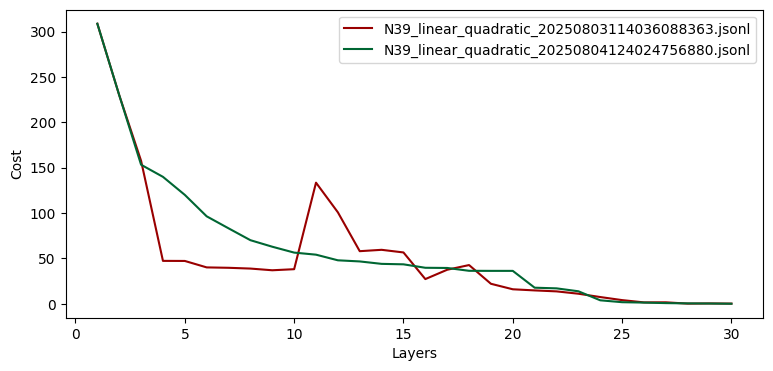

In [ ]:
experiments = [
    'N39_linear_quadratic_20250803114036088363.jsonl',
    'N39_linear_quadratic_20250804124024756880.jsonl'
]

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, filepath in enumerate(experiments):
    filename = filepath.split('/')[-1]
    experiment = '_'.join(filename.split('_')[:-1])
    df_i = experiment_results[experiment_results['filepath']==f'{filepath}']
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=filename)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend();

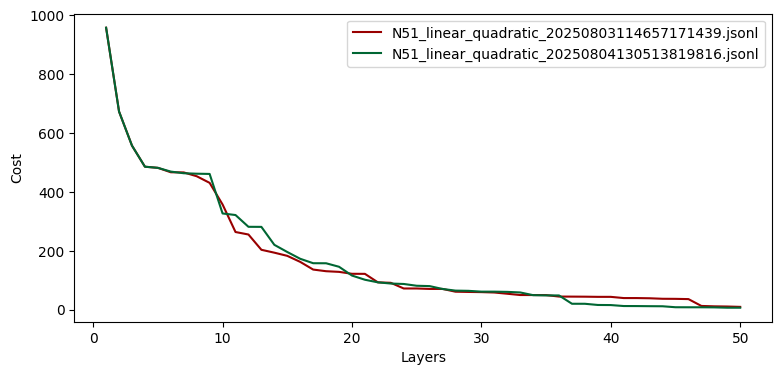

In [ ]:
experiments = [
    'N51_linear_quadratic_20250803114657171439.jsonl',
    'N51_linear_quadratic_20250804130513819816.jsonl'
]

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, filepath in enumerate(experiments):
    filename = filepath.split('/')[-1]
    experiment = '_'.join(filename.split('_')[:-1])
    df_i = experiment_results[experiment_results['filepath']==f'{filepath}']
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=filename)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend();

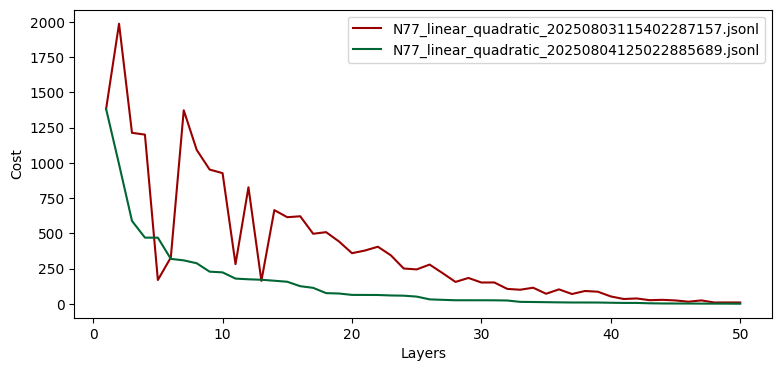

In [ ]:
experiments = [
    'N77_linear_quadratic_20250803115402287157.jsonl',
    'N77_linear_quadratic_20250804125022885689.jsonl'
]

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, filepath in enumerate(experiments):
    filename = filepath.split('/')[-1]
    experiment = '_'.join(filename.split('_')[:-1])
    df_i = experiment_results[experiment_results['filepath']==f'{filepath}']
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=filename)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend();

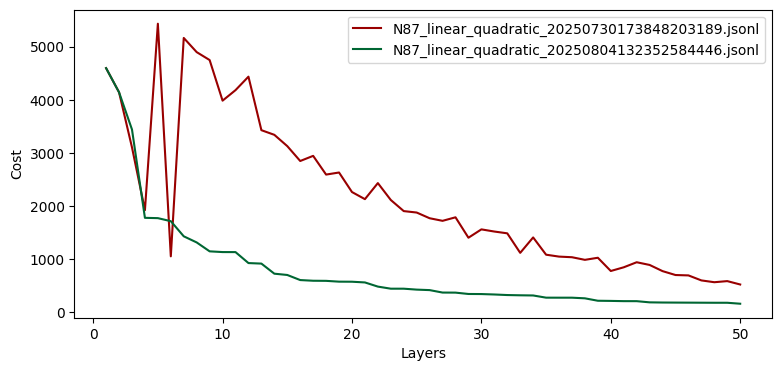

In [ ]:
experiments = [
    'N87_linear_quadratic_20250730173848203189.jsonl',
    'N87_linear_quadratic_20250804132352584446.jsonl'
]

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, filepath in enumerate(experiments):
    filename = filepath.split('/')[-1]
    experiment = '_'.join(filename.split('_')[:-1])
    df_i = experiment_results[experiment_results['filepath']==f'{filepath}']
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=filename)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend();

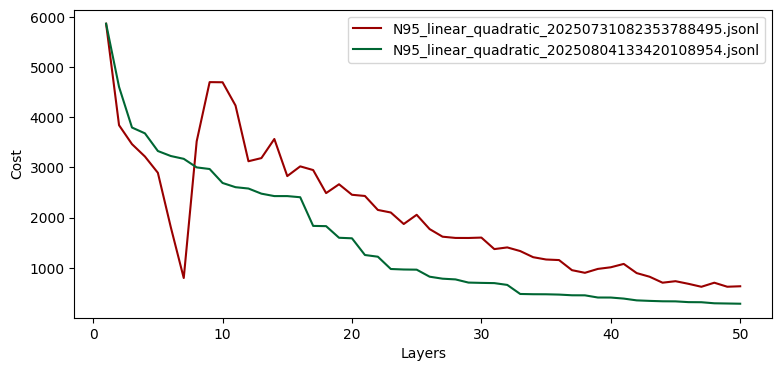

In [ ]:
experiments = [
    'N95_linear_quadratic_20250731082353788495.jsonl',
    'N95_linear_quadratic_20250804133420108954.jsonl'
]

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, filepath in enumerate(experiments):
    filename = filepath.split('/')[-1]
    experiment = '_'.join(filename.split('_')[:-1])
    df_i = experiment_results[experiment_results['filepath']==f'{filepath}']
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=filename)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend();

### Others

In [ ]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.5

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)

num_qubits = df.loc[0, 'num_qubits']
solutions = compute_solution(N)
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

pops_50 =  df[df['layers']==50].reset_index().loc[0, 'state_populations']
pops_100 =  df[df['layers']==100].reset_index().loc[0, 'state_populations']

fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].bar(x_hist, pops_50, color=bar_colors)
axs[1].bar(x_hist, pops_100, color=bar_colors)
axs[0].set_ylabel('Prob')
axs[0].set_xlabel('Computational basis')
axs[1].set_xlabel('Computational basis')

axs[0].set_xticks(range(2**num_qubits), "")
axs[0].xaxis.set_major_locator(ticker.NullLocator())
axs[0].set_title('p = 50')
axs[1].set_xticks(range(2**num_qubits), "")
axs[1].xaxis.set_major_locator(ticker.NullLocator())
axs[1].set_title('p = 100');

KeyError: 0

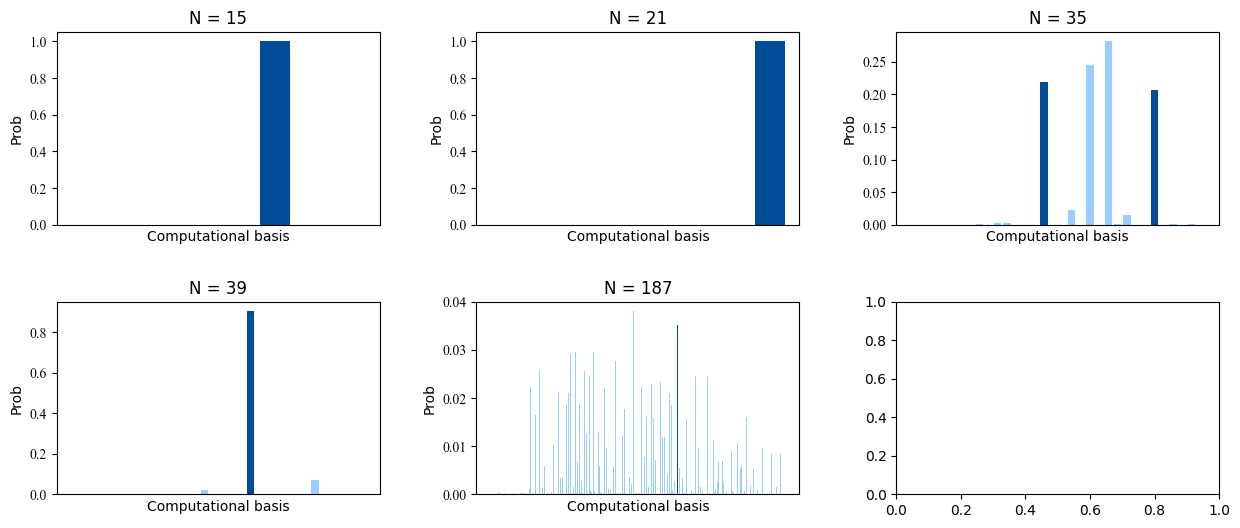

In [ ]:
df = experiment_results[(experiment_results['setup']=='standard') & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']<=187)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    num_qubits = df_N.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_N.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

    axs[i].bar(x_hist, pops, color=bar_colors)
    axs[i].set_ylim(0)
    axs[i].set_ylabel('Prob')
    axs[i].set_xlabel('Computational basis')

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].set_xticks(range(2**num_qubits), "")
    axs[i].xaxis.set_major_locator(ticker.NullLocator())
    axs[i].set_title(f'N = {N}')

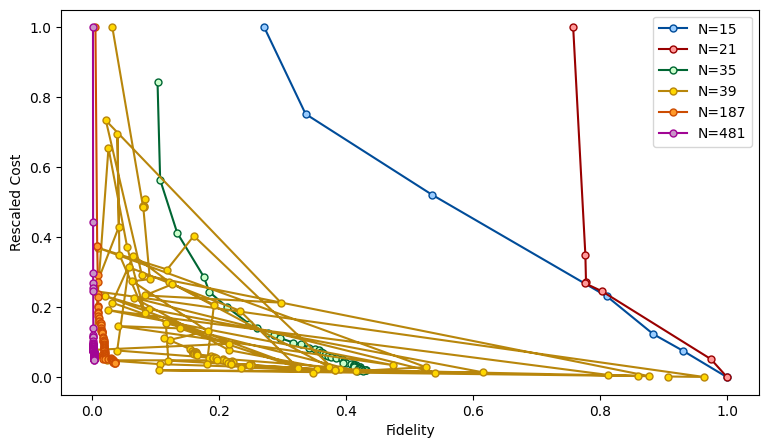

In [ ]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

fig = plt.figure(figsize=(9,5))

for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    plt.plot(df_N['fidelity'], df_N['cost_rescaled'], label=f'N={N}',
             color=plot_colors[i+1][0], mec=plot_colors[i+1][0], mfc=plot_colors[i+1][1], marker='.',
             markersize=10)

plt.xlabel('Fidelity')
plt.ylabel('Rescaled Cost')
#plt.yscale('log')
plt.legend(loc='best')
#plt.show()

# plt.savefig('../report_1/img/cost_fidelity.pdf')